In [ ]:
## Problem Statement
Data is being recorded from various condition monitoring sensors in a manufacturing plant. 
There are hundreds of such sensors which may be impacting the quality of final product which is getting manufactured.
Each row of data set refers to a batch of the process and a data collected for 55 sensors at different intervals of time.

Given the past data, task is to predict the target variable (could be an efficiency factor - though is it not explicitly mentioned)

ALL RESULTS 1: Comparison

MODEL                                 PLAIN Model      With Reduced Observation    With feature Drops
ElasticNet (alpha=1.0, l1_ratio=0.5)  0.24             0.26                        0.25
GradientBoostingRegressor             0.27             0.28                        0.25
LGBMRegressor                         0.24             0.24                        0.25
Ridge      (alpha=0.5,0.7,0.2)        0.18             0.18                        0.2
RandomForestRegressor                 0.03             0.03                        0.16
Lars                                  0.17             0.03                        0.16
LarsCV                                0.25             0.25                        0.25
LassoLars                             0.00             0.00                        0.00
LassoLarsCV                           0.26             0.26                        0.27
CatBoostRegressor                     0.38             0.39                        0.34
HuberRegressor                        0.24             0.21                        0.19
RANSACRegressor                       0.21             -6.69                       6.43
TheilSenRegressor                     0.27             -0.2                        0.13
PassiveAggressiveRegressor            0.11             -3.95                       -7.43
BaggingRegressor                      0.08             0.01                        0.05
AdaBoostRegressor                     0.04             0.07                        0.05
SVR                                   0.03             0.01                        0.01

NOTES: 
In general removel of features either by EDA or through RFECV did not bring about much changes in the model performances.
CatBoostRegressor outclassed other models in all the cases
Removal of outliers (miniscule values that were power of -11) did not help. In fact that affeceted negetively
NEXTSTEPS: Understand the models from fundamentals and decipher why there was - no effect, negetive effect,positive effect with differing techniques.
   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier                                  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split   
pd.set_option('display.max_columns',None)
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier,RandomForestRegressor

from sklearn.linear_model import LinearRegression,LogisticRegression,LogisticRegressionCV, RidgeCV, Lars,LarsCV,LassoLars,LassoLarsCV        
from sklearn import metrics 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn import linear_model
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

#gbrt=GradientBoostingRegressor(n_estimators=100)
#reg = linear_model.Ridge(alpha=.5)
#reg_rf1=RandomForestRegressor()
# XGBRegressor, LGBMRegressor,CatBoostRegressor
#LogisticRegression,LogisticRegressionCV, RidgeCV, Lars,LarsCV,LassoLars,LassoLarsCV

#ADDED all the required Libraries.


## Data Loading and Cleaning
#doublecheck the current directory
#change directory to 'data'

In [2]:
import os
print(os.getcwd())
os.chdir('./data')
print(os.getcwd())

C:\Users\BLR_01\Pictures\Geyitm\hackDec17Jan2iot
C:\Users\BLR_01\Pictures\Geyitm\hackDec17Jan2iot\data


# Read the data.

In [3]:
# Load the dataframe: both initial train and test 
df_train_initial = pd.read_csv('train.csv',delimiter=',')
df_test_initial =pd.read_csv('test.csv',delimiter=',')

#find the shapes of initial data
print('Shape of train_initial: ',df_train_initial.shape)
print('Shape of test_initial: ',df_test_initial.shape)


('Shape of train_initial: ', (794, 387))
('Shape of test_initial: ', (89, 386))


# find the headeares

In [4]:
# info on train data initial
df_train_initial.head()

,Id,x0_t0,x0_t1,x0_t2,x0_t3,x0_t4,x0_t5,x0_t6,x1_t0,x1_t1,x1_t2,x1_t3,x1_t4,x1_t5,x1_t6,x2_t0,x2_t1,x2_t2,x2_t3,x2_t4,x2_t5,x2_t6,x3_t0,x3_t1,x3_t2,x3_t3,x3_t4,x3_t5,x3_t6,x4_t0,x4_t1,x4_t2,x4_t3,x4_t4,x4_t5,x4_t6,x5_t0,x5_t1,x5_t2,x5_t3,x5_t4,x5_t5,x5_t6,x6_t0,x6_t1,x6_t2,x6_t3,x6_t4,x6_t5,x6_t6,x7_t0,x7_t1,x7_t2,x7_t3,x7_t4,x7_t5,x7_t6,x8_t0,x8_t1,x8_t2,x8_t3,x8_t4,x8_t5,x8_t6,x9_t0,x9_t1,x9_t2,x9_t3,x9_t4,x9_t5,x9_t6,x10_t0,x10_t1,x10_t2,x10_t3,x10_t4,x10_t5,x10_t6,x11_t0,x11_t1,x11_t2,x11_t3,x11_t4,x11_t5,x11_t6,x12_t0,x12_t1,x12_t2,x12_t3,x12_t4,x12_t5,x12_t6,x13_t0,x13_t1,x13_t2,x13_t3,x13_t4,x13_t5,x13_t6,x14_t0,x14_t1,x14_t2,x14_t3,x14_t4,x14_t5,x14_t6,x15_t0,x15_t1,x15_t2,x15_t3,x15_t4,x15_t5,x15_t6,x16_t0,x16_t1,x16_t2,x16_t3,x16_t4,x16_t5,x16_t6,x17_t0,x17_t1,x17_t2,x17_t3,x17_t4,x17_t5,x17_t6,x18_t0,x18_t1,x18_t2,x18_t3,x18_t4,x18_t5,x18_t6,x19_t0,x19_t1,x19_t2,x19_t3,x19_t4,x19_t5,x19_t6,x20_t0,x20_t1,x20_t2,x20_t3,x20_t4,x20_t5,x20_t6,x21_t0,x21_t1,x21_t2,x21_t3,x21_t4,x21_t5,x21_t6,x22_t0,x22_t1,x22_t2,x22_t3,x22_t4,x22_t5,x22_t6,x23_t0,x23_t1,x23_t2,x23_t3,x23_t4,x23_t5,x23_t6,x24_t0,x24_t1,x24_t2,x24_t3,x24_t4,x24_t5,x24_t6,x25_t0,x25_t1,x25_t2,x25_t3,x25_t4,x25_t5,x25_t6,x26_t0,x26_t1,x26_t2,x26_t3,x26_t4,x26_t5,x26_t6,x27_t0,x27_t1,x27_t2,x27_t3,x27_t4,x27_t5,x27_t6,x28_t0,x28_t1,x28_t2,x28_t3,x28_t4,x28_t5,x28_t6,x29_t0,x29_t1,x29_t2,x29_t3,x29_t4,x29_t5,x29_t6,x30_t0,x30_t1,x30_t2,x30_t3,x30_t4,x30_t5,x30_t6,x32_t0,x32_t1,x32_t2,x32_t3,x32_t4,x32_t5,x32_t6,x31_t0,x31_t1,x31_t2,x31_t3,x31_t4,x31_t5,x31_t6,x34_t0,x34_t1,x34_t2,x34_t3,x34_t4,x34_t5,x34_t6,x33_t0,x33_t1,x33_t2,x33_t3,x33_t4,x33_t5,x33_t6,x36_t0,x36_t1,x36_t2,x36_t3,x36_t4,x36_t5,x36_t6,x35_t0,x35_t1,x35_t2,x35_t3,x35_t4,x35_t5,x35_t6,x37_t0,x37_t1,x37_t2,x37_t3,x37_t4,x37_t5,x37_t6,x38_t0,x38_t1,x38_t2,x38_t3,x38_t4,x38_t5,x38_t6,x39_t0,x39_t1,x39_t2,x39_t3,x39_t4,x39_t5,x39_t6,x40_t0,x40_t1,x40_t2,x40_t3,x40_t4,x40_t5,x40_t6,x41_t0,x41_t1,x41_t2,x41_t3,x41_t4,x41_t5,x41_t6,x42_t0,x42_t1,x42_t2,x42_t3,x42_t4,x42_t5,x42_t6,x43_t0,x43_t1,x43_t2,x43_t3,x43_t4,x43_t5,x43_t6,x44_t0,x44_t1,x44_t2,x44_t3,x44_t4,x44_t5,x44_t6,x45_t0,x45_t1,x45_t2,x45_t3,x45_t4,x45_t5,x45_t6,x46_t0,x46_t1,x46_t2,x46_t3,x46_t4,x46_t5,x46_t6,x47_t0,x47_t1,x47_t2,x47_t3,x47_t4,x47_t5,x47_t6,x48_t0,x48_t1,x48_t2,x48_t3,x48_t4,x48_t5,x48_t6,x49_t0,x49_t1,x49_t2,x49_t3,x49_t4,x49_t5,x49_t6,x50_t0,x50_t1,x50_t2,x50_t3,x50_t4,x50_t5,x50_t6,x51_t0,x51_t1,x51_t2,x51_t3,x51_t4,x51_t5,x51_t6,x52_t0,x52_t1,x52_t2,x52_t3,x52_t4,x52_t5,x52_t6,x53_t0,x53_t1,x53_t2,x53_t3,x53_t4,x53_t5,x53_t6,x54_t0,x54_t1,x54_t2,x54_t3,x54_t4,x54_t5,x54_t6,y2
0,136,747.198063,759.454972,739.141623,737.392174,743.302320,745.373210,738.268949,-1.160000e-11,-1.160000e-11,0.000000e+00,1.160000e-11,1.160000e-11,1.160000e-11,0.000000,1,1,1,1,1,1,1,17.201552,27.682003,27.957075,27.946312,28.000356,27.907155,0.416150,6.70,6.70,6.70,6.70,6.70,6.70,6.70,662.422558,679.789474,662.077819,673.703417,660.476145,662.624351,658.431064,835.900024,835.900024,835.900024,835.900024,835.900024,835.900024,835.900024,845.299988,845.299988,845.299988,845.299988,845.299988,845.299988,845.299988,4.6,4.6,4.6,4.6,4.6,4.6,4.6,0.347799,0.286360,0.286337,0.183438,0.205659,0.190233,0.186594,87.420009,80.664716,80.742491,80.771806,80.739311,80.722909,40.145942,80.720398,81.913527,80.354433,76.780788,75.947264,70.191626,74.393137,467.472547,459.298533,457.701529,457.167227,454.400050,452.977750,466.185716,545.313232,542.876178,539.754676,534.870813,527.422045,524.262217,541.735800,0.909639,0.909631,0.909618,0.909652,0.909680,0.909713,0.909678,1700,1700,1700,1700.0,1700,1700.0,1700.00,55,55,55,55,55,55,55.00,695.333236,695.031441,691.987332,692.497389,699.013104,697.038433,695.213257,80,80,80,80,80,80,80,80.0,80.0,80.0,80.0,80.0,80.0,80.0,1.0,1.0,1.0,1.0,1.0,1,1,29.0,29.0,29.0,28.882927,28.421845,28.122549,28.0,787.968486,594.472819,765.554625,774.029942,782.797139,779.983872,775.29,0.681770,0.558833,0.649518,0.547491,0.621654,0.381358

In [5]:
# info on test data
df_test_initial.head()

,Id,x0_t0,x0_t1,x0_t2,x0_t3,x0_t4,x0_t5,x0_t6,x1_t0,x1_t1,x1_t2,x1_t3,x1_t4,x1_t5,x1_t6,x2_t0,x2_t1,x2_t2,x2_t3,x2_t4,x2_t5,x2_t6,x3_t0,x3_t1,x3_t2,x3_t3,x3_t4,x3_t5,x3_t6,x4_t0,x4_t1,x4_t2,x4_t3,x4_t4,x4_t5,x4_t6,x5_t0,x5_t1,x5_t2,x5_t3,x5_t4,x5_t5,x5_t6,x6_t0,x6_t1,x6_t2,x6_t3,x6_t4,x6_t5,x6_t6,x7_t0,x7_t1,x7_t2,x7_t3,x7_t4,x7_t5,x7_t6,x8_t0,x8_t1,x8_t2,x8_t3,x8_t4,x8_t5,x8_t6,x9_t0,x9_t1,x9_t2,x9_t3,x9_t4,x9_t5,x9_t6,x10_t0,x10_t1,x10_t2,x10_t3,x10_t4,x10_t5,x10_t6,x11_t0,x11_t1,x11_t2,x11_t3,x11_t4,x11_t5,x11_t6,x12_t0,x12_t1,x12_t2,x12_t3,x12_t4,x12_t5,x12_t6,x13_t0,x13_t1,x13_t2,x13_t3,x13_t4,x13_t5,x13_t6,x14_t0,x14_t1,x14_t2,x14_t3,x14_t4,x14_t5,x14_t6,x15_t0,x15_t1,x15_t2,x15_t3,x15_t4,x15_t5,x15_t6,x16_t0,x16_t1,x16_t2,x16_t3,x16_t4,x16_t5,x16_t6,x17_t0,x17_t1,x17_t2,x17_t3,x17_t4,x17_t5,x17_t6,x18_t0,x18_t1,x18_t2,x18_t3,x18_t4,x18_t5,x18_t6,x19_t0,x19_t1,x19_t2,x19_t3,x19_t4,x19_t5,x19_t6,x20_t0,x20_t1,x20_t2,x20_t3,x20_t4,x20_t5,x20_t6,x21_t0,x21_t1,x21_t2,x21_t3,x21_t4,x21_t5,x21_t6,x22_t0,x22_t1,x22_t2,x22_t3,x22_t4,x22_t5,x22_t6,x23_t0,x23_t1,x23_t2,x23_t3,x23_t4,x23_t5,x23_t6,x24_t0,x24_t1,x24_t2,x24_t3,x24_t4,x24_t5,x24_t6,x25_t0,x25_t1,x25_t2,x25_t3,x25_t4,x25_t5,x25_t6,x26_t0,x26_t1,x26_t2,x26_t3,x26_t4,x26_t5,x26_t6,x27_t0,x27_t1,x27_t2,x27_t3,x27_t4,x27_t5,x27_t6,x28_t0,x28_t1,x28_t2,x28_t3,x28_t4,x28_t5,x28_t6,x29_t0,x29_t1,x29_t2,x29_t3,x29_t4,x29_t5,x29_t6,x30_t0,x30_t1,x30_t2,x30_t3,x30_t4,x30_t5,x30_t6,x32_t0,x32_t1,x32_t2,x32_t3,x32_t4,x32_t5,x32_t6,x31_t0,x31_t1,x31_t2,x31_t3,x31_t4,x31_t5,x31_t6,x34_t0,x34_t1,x34_t2,x34_t3,x34_t4,x34_t5,x34_t6,x33_t0,x33_t1,x33_t2,x33_t3,x33_t4,x33_t5,x33_t6,x36_t0,x36_t1,x36_t2,x36_t3,x36_t4,x36_t5,x36_t6,x35_t0,x35_t1,x35_t2,x35_t3,x35_t4,x35_t5,x35_t6,x37_t0,x37_t1,x37_t2,x37_t3,x37_t4,x37_t5,x37_t6,x38_t0,x38_t1,x38_t2,x38_t3,x38_t4,x38_t5,x38_t6,x39_t0,x39_t1,x39_t2,x39_t3,x39_t4,x39_t5,x39_t6,x40_t0,x40_t1,x40_t2,x40_t3,x40_t4,x40_t5,x40_t6,x41_t0,x41_t1,x41_t2,x41_t3,x41_t4,x41_t5,x41_t6,x42_t0,x42_t1,x42_t2,x42_t3,x42_t4,x42_t5,x42_t6,x43_t0,x43_t1,x43_t2,x43_t3,x43_t4,x43_t5,x43_t6,x44_t0,x44_t1,x44_t2,x44_t3,x44_t4,x44_t5,x44_t6,x45_t0,x45_t1,x45_t2,x45_t3,x45_t4,x45_t5,x45_t6,x46_t0,x46_t1,x46_t2,x46_t3,x46_t4,x46_t5,x46_t6,x47_t0,x47_t1,x47_t2,x47_t3,x47_t4,x47_t5,x47_t6,x48_t0,x48_t1,x48_t2,x48_t3,x48_t4,x48_t5,x48_t6,x49_t0,x49_t1,x49_t2,x49_t3,x49_t4,x49_t5,x49_t6,x50_t0,x50_t1,x50_t2,x50_t3,x50_t4,x50_t5,x50_t6,x51_t0,x51_t1,x51_t2,x51_t3,x51_t4,x51_t5,x51_t6,x52_t0,x52_t1,x52_t2,x52_t3,x52_t4,x52_t5,x52_t6,x53_t0,x53_t1,x53_t2,x53_t3,x53_t4,x53_t5,x53_t6,x54_t0,x54_t1,x54_t2,x54_t3,x54_t4,x54_t5,x54_t6
0,8,764.697648,765.563295,765.508731,764.860651,768.902751,762.688871,750.95000,0.819072,0.812704,0.810363,0.792246,0.822421,0.817566,1.376000,1,1,1,1,1,1,1,22.168429,21.923296,21.913781,22.001711,21.949279,22.015483,27.900000,6.7,6.7,6.7,6.7,6.7,6.7,6.9,726.715924,722.177154,721.412400,717.727924,702.398486,743.128153,746.300000,841.0,841.0,841.0,841.0,841.0,841.0,795.83,829.099976,829.099976,829.099976,829.099976,829.099976,829.099976,816.480000,4.4,4.4,4.4,4.4,4.4,4.4,4.4,0.052929,0.079950,0.109169,0.055721,0.104747,0.052091,0.310000,81.971545,82.019554,82.008675,82.095678,81.886532,81.841905,81.490000,15.596411,11.029808,9.503865,6.743415,3.334483,1.795610,9.400000,477.908943,475.812495,474.955049,473.688576,472.364045,470.925838,421.730000,489.689672,487.285033,485.307179,482.426794,476.151760,468.371217,495.53000,0.932122,0.932091,0.932077,0.932108,0.931923,0.931880,0.900000,1300,1300,1300.0,1300,1300,1300,1704.25,66,66,66,66,66,66,55.66,694.467864,692.623602,698.484748,699.778779,698.958447,694.238372,697.240000,80,80,80,80,80,80,80,80,80,80,80,80,80,80,1,1.0,1.0,1,1,1,1,29.000000,29.059856,29.97561,28.101707,27.956436,27.000000,27.0,786.299009,787.260579,783.071683,783.884106,786.722014,775.290000,775.29,0.559376,0.565709,0.545072,0.551684,0.437161,0.590000,0.59,1,1,1,0,1,0.5,0.5,0,0,0,0,0,0,0,8.590020,8.522802,9.856547,10.786897,9.743646,10

In [6]:
# More views of training data in different ways 
df_train_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Columns: 387 entries, Id to y2
dtypes: float64(315), int64(72)
memory usage: 2.3 MB


In [7]:
df_train_initial.describe()

,Id,x0_t0,x0_t1,x0_t2,x0_t3,x0_t4,x0_t5,x0_t6,x1_t0,x1_t1,x1_t2,x1_t3,x1_t4,x1_t5,x1_t6,x2_t0,x2_t1,x2_t2,x2_t3,x2_t4,x2_t5,x2_t6,x3_t0,x3_t1,x3_t2,x3_t3,x3_t4,x3_t5,x3_t6,x4_t0,x4_t1,x4_t2,x4_t3,x4_t4,x4_t5,x4_t6,x5_t0,x5_t1,x5_t2,x5_t3,x5_t4,x5_t5,x5_t6,x6_t0,x6_t1,x6_t2,x6_t3,x6_t4,x6_t5,x6_t6,x7_t0,x7_t1,x7_t2,x7_t3,x7_t4,x7_t5,x7_t6,x8_t0,x8_t1,x8_t2,x8_t3,x8_t4,x8_t5,x8_t6,x9_t0,x9_t1,x9_t2,x9_t3,x9_t4,x9_t5,x9_t6,x10_t0,x10_t1,x10_t2,x10_t3,x10_t4,x10_t5,x10_t6,x11_t0,x11_t1,x11_t2,x11_t3,x11_t4,x11_t5,x11_t6,x12_t0,x12_t1,x12_t2,x12_t3,x12_t4,x12_t5,x12_t6,x13_t0,x13_t1,x13_t2,x13_t3,x13_t4,x13_t5,x13_t6,x14_t0,x14_t1,x14_t2,x14_t3,x14_t4,x14_t5,x14_t6,x15_t0,x15_t1,x15_t2,x15_t3,x15_t4,x15_t5,x15_t6,x16_t0,x16_t1,x16_t2,x16_t3,x16_t4,x16_t5,x16_t6,x17_t0,x17_t1,x17_t2,x17_t3,x17_t4,x17_t5,x17_t6,x18_t0,x18_t1,x18_t2,x18_t3,x18_t4,x18_t5,x18_t6,x19_t0,x19_t1,x19_t2,x19_t3,x19_t4,x19_t5,x19_t6,x20_t0,x20_t1,x20_t2,x20_t3,x20_t4,x20_t5,x20_t6,x21_t0,x21_t1,x21_t2,x21_t3,x21_t4,x21_t5,x21_t6,x22_t0,x22_t1,x22_t2,x22_t3,x22_t4,x22_t5,x22_t6,x23_t0,x23_t1,x23_t2,x23_t3,x23_t4,x23_t5,x23_t6,x24_t0,x24_t1,x24_t2,x24_t3,x24_t4,x24_t5,x24_t6,x25_t0,x25_t1,x25_t2,x25_t3,x25_t4,x25_t5,x25_t6,x26_t0,x26_t1,x26_t2,x26_t3,x26_t4,x26_t5,x26_t6,x27_t0,x27_t1,x27_t2,x27_t3,x27_t4,x27_t5,x27_t6,x28_t0,x28_t1,x28_t2,x28_t3,x28_t4,x28_t5,x28_t6,x29_t0,x29_t1,x29_t2,x29_t3,x29_t4,x29_t5,x29_t6,x30_t0,x30_t1,x30_t2,x30_t3,x30_t4,x30_t5,x30_t6,x32_t0,x32_t1,x32_t2,x32_t3,x32_t4,x32_t5,x32_t6,x31_t0,x31_t1,x31_t2,x31_t3,x31_t4,x31_t5,x31_t6,x34_t0,x34_t1,x34_t2,x34_t3,x34_t4,x34_t5,x34_t6,x33_t0,x33_t1,x33_t2,x33_t3,x33_t4,x33_t5,x33_t6,x36_t0,x36_t1,x36_t2,x36_t3,x36_t4,x36_t5,x36_t6,x35_t0,x35_t1,x35_t2,x35_t3,x35_t4,x35_t5,x35_t6,x37_t0,x37_t1,x37_t2,x37_t3,x37_t4,x37_t5,x37_t6,x38_t0,x38_t1,x38_t2,x38_t3,x38_t4,x38_t5,x38_t6,x39_t0,x39_t1,x39_t2,x39_t3,x39_t4,x39_t5,x39_t6,x40_t0,x40_t1,x40_t2,x40_t3,x40_t4,x40_t5,x40_t6,x41_t0,x41_t1,x41_t2,x41_t3,x41_t4,x41_t5,x41_t6,x42_t0,x42_t1,x42_t2,x42_t3,x42_t4,x42_t5,x42_t6,x43_t0,x43_t1,x43_t2,x43_t3,x43_t4,x43_t5,x43_t6,x44_t0,x44_t1,x44_t2,x44_t3,x44_t4,x44_t5,x44_t6,x45_t0,x45_t1,x45_t2,x45_t3,x45_t4,x45_t5,x45_t6,x46_t0,x46_t1,x46_t2,x46_t3,x46_t4,x46_t5,x46_t6,x47_t0,x47_t1,x47_t2,x47_t3,x47_t4,x47_t5,x47_t6,x48_t0,x48_t1,x48_t2,x48_t3,x48_t4,x48_t5,x48_t6,x49_t0,x49_t1,x49_t2,x49_t3,x49_t4,x49_t5,x49_t6,x50_t0,x50_t1,x50_t2,x50_t3,x50_t4,x50_t5,x50_t6,x51_t0,x51_t1,x51_t2,x51_t3,x51_t4,x51_t5,x51_t6,x52_t0,x52_t1,x52_t2,x52_t3,x52_t4,x52_t5,x52_t6,x53_t0,x53_t1,x53_t2,x53_t3,x53_t4,x53_t5,x53_t6,x54_t0,x54_t1,x54_t2,x54_t3,x54_t4,x54_t5,x54_t6,y2
count,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,7.940000e+02,7.940000e+02,7.940000e+02,7.940000e+02,7.940000e+02,7.940000e+02,7.940000e+02,794.0,794.0,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,7.940000e+02,7.940000e+02,794.000000,7.940000e+02,7.940000e+02,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,7.940000e+02,794.000000,7.940000e+02,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.

#Finding null values

In [8]:
#df_train_initial.isna().sum()

In [9]:
#test missing values
#df_train_initial.isna().sum()

In [10]:
#first find the outliers.

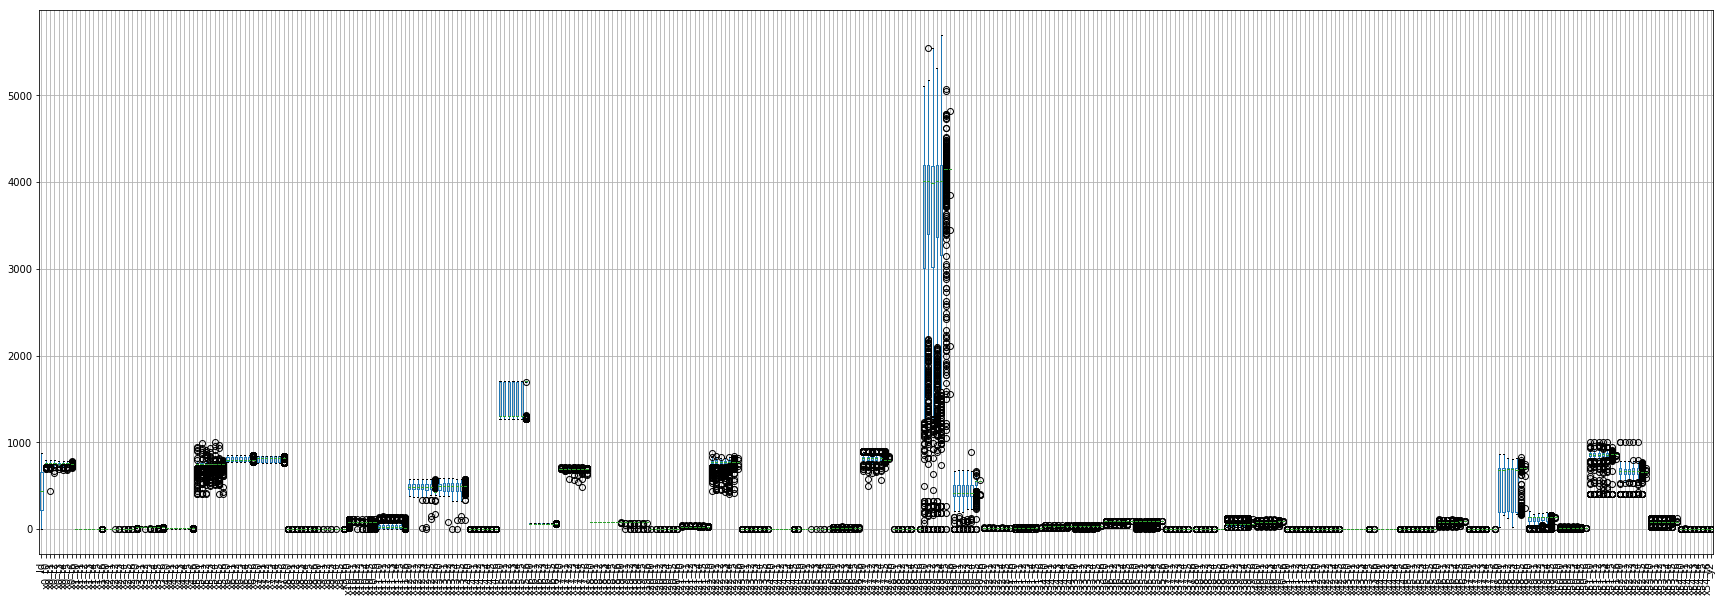

In [11]:
df_train_initial.boxplot(rot=90, figsize=(30,10))

In [12]:
#No much insight with all the graphs, so lets try with  - percentile

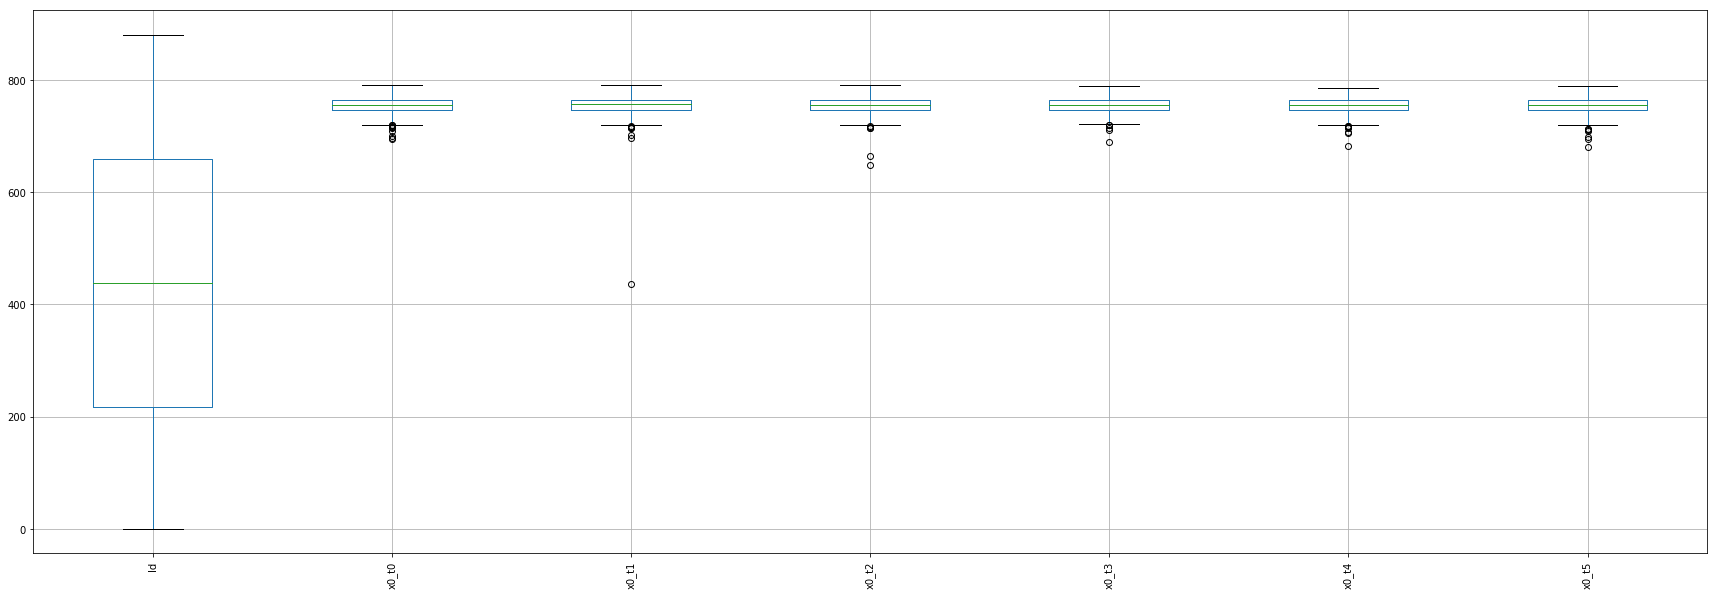

In [13]:
df_train_initial.iloc[:,0:7].boxplot(rot=90, figsize=(30,10)) # we could do for other series as well

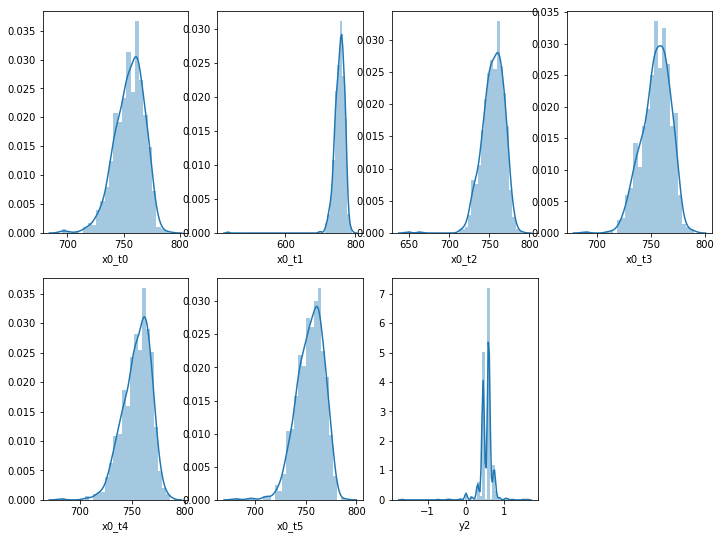

In [34]:
f, ax = plt.subplots(figsize=(12, 9))

plt.subplot(241)
sns.distplot(df_train_initial['x0_t0'])

plt.subplot(242)
sns.distplot(df_train_initial['x0_t1'])

plt.subplot(243)
sns.distplot(df_train_initial['x0_t2'])

plt.subplot(244)
sns.distplot(df_train_initial['x0_t3'])

plt.subplot(245)
sns.distplot(df_train_initial['x0_t4'])

plt.subplot(246)
sns.distplot(df_train_initial['x0_t5'])

plt.subplot(247)
sns.distplot(df_train_initial['y2'])



#bservation - all data is mostly well distributed

#continue the analysis

In [15]:
#sns.pairplot(df_train_initial)

#Observe the correlations with price


In [16]:
#Another way of seeing correlations
c=df_train_initial.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")

In [17]:
so.tail()

y2  x25_t1   NaN
    x37_t6   NaN
    x38_t5   NaN
    x38_t6   NaN
    x42_t6   NaN
dtype: float64

In [18]:
# try https://www.dezyre.com/recipes/drop-out-highly-correlated-features-in-python -- remove highly correlated features

#For that we will make two copies of bases datasets

In [19]:
#making copies of datasets one set for encoding types another for hostid
df_train_hostid_label=df_train_initial.copy()

In [20]:
#check data
df_train_hostid_label.info() # we are good

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Columns: 387 entries, Id to y2
dtypes: float64(315), int64(72)
memory usage: 2.3 MB


In [21]:
df_train_hostid_label.describe() 


,Id,x0_t0,x0_t1,x0_t2,x0_t3,x0_t4,x0_t5,x0_t6,x1_t0,x1_t1,x1_t2,x1_t3,x1_t4,x1_t5,x1_t6,x2_t0,x2_t1,x2_t2,x2_t3,x2_t4,x2_t5,x2_t6,x3_t0,x3_t1,x3_t2,x3_t3,x3_t4,x3_t5,x3_t6,x4_t0,x4_t1,x4_t2,x4_t3,x4_t4,x4_t5,x4_t6,x5_t0,x5_t1,x5_t2,x5_t3,x5_t4,x5_t5,x5_t6,x6_t0,x6_t1,x6_t2,x6_t3,x6_t4,x6_t5,x6_t6,x7_t0,x7_t1,x7_t2,x7_t3,x7_t4,x7_t5,x7_t6,x8_t0,x8_t1,x8_t2,x8_t3,x8_t4,x8_t5,x8_t6,x9_t0,x9_t1,x9_t2,x9_t3,x9_t4,x9_t5,x9_t6,x10_t0,x10_t1,x10_t2,x10_t3,x10_t4,x10_t5,x10_t6,x11_t0,x11_t1,x11_t2,x11_t3,x11_t4,x11_t5,x11_t6,x12_t0,x12_t1,x12_t2,x12_t3,x12_t4,x12_t5,x12_t6,x13_t0,x13_t1,x13_t2,x13_t3,x13_t4,x13_t5,x13_t6,x14_t0,x14_t1,x14_t2,x14_t3,x14_t4,x14_t5,x14_t6,x15_t0,x15_t1,x15_t2,x15_t3,x15_t4,x15_t5,x15_t6,x16_t0,x16_t1,x16_t2,x16_t3,x16_t4,x16_t5,x16_t6,x17_t0,x17_t1,x17_t2,x17_t3,x17_t4,x17_t5,x17_t6,x18_t0,x18_t1,x18_t2,x18_t3,x18_t4,x18_t5,x18_t6,x19_t0,x19_t1,x19_t2,x19_t3,x19_t4,x19_t5,x19_t6,x20_t0,x20_t1,x20_t2,x20_t3,x20_t4,x20_t5,x20_t6,x21_t0,x21_t1,x21_t2,x21_t3,x21_t4,x21_t5,x21_t6,x22_t0,x22_t1,x22_t2,x22_t3,x22_t4,x22_t5,x22_t6,x23_t0,x23_t1,x23_t2,x23_t3,x23_t4,x23_t5,x23_t6,x24_t0,x24_t1,x24_t2,x24_t3,x24_t4,x24_t5,x24_t6,x25_t0,x25_t1,x25_t2,x25_t3,x25_t4,x25_t5,x25_t6,x26_t0,x26_t1,x26_t2,x26_t3,x26_t4,x26_t5,x26_t6,x27_t0,x27_t1,x27_t2,x27_t3,x27_t4,x27_t5,x27_t6,x28_t0,x28_t1,x28_t2,x28_t3,x28_t4,x28_t5,x28_t6,x29_t0,x29_t1,x29_t2,x29_t3,x29_t4,x29_t5,x29_t6,x30_t0,x30_t1,x30_t2,x30_t3,x30_t4,x30_t5,x30_t6,x32_t0,x32_t1,x32_t2,x32_t3,x32_t4,x32_t5,x32_t6,x31_t0,x31_t1,x31_t2,x31_t3,x31_t4,x31_t5,x31_t6,x34_t0,x34_t1,x34_t2,x34_t3,x34_t4,x34_t5,x34_t6,x33_t0,x33_t1,x33_t2,x33_t3,x33_t4,x33_t5,x33_t6,x36_t0,x36_t1,x36_t2,x36_t3,x36_t4,x36_t5,x36_t6,x35_t0,x35_t1,x35_t2,x35_t3,x35_t4,x35_t5,x35_t6,x37_t0,x37_t1,x37_t2,x37_t3,x37_t4,x37_t5,x37_t6,x38_t0,x38_t1,x38_t2,x38_t3,x38_t4,x38_t5,x38_t6,x39_t0,x39_t1,x39_t2,x39_t3,x39_t4,x39_t5,x39_t6,x40_t0,x40_t1,x40_t2,x40_t3,x40_t4,x40_t5,x40_t6,x41_t0,x41_t1,x41_t2,x41_t3,x41_t4,x41_t5,x41_t6,x42_t0,x42_t1,x42_t2,x42_t3,x42_t4,x42_t5,x42_t6,x43_t0,x43_t1,x43_t2,x43_t3,x43_t4,x43_t5,x43_t6,x44_t0,x44_t1,x44_t2,x44_t3,x44_t4,x44_t5,x44_t6,x45_t0,x45_t1,x45_t2,x45_t3,x45_t4,x45_t5,x45_t6,x46_t0,x46_t1,x46_t2,x46_t3,x46_t4,x46_t5,x46_t6,x47_t0,x47_t1,x47_t2,x47_t3,x47_t4,x47_t5,x47_t6,x48_t0,x48_t1,x48_t2,x48_t3,x48_t4,x48_t5,x48_t6,x49_t0,x49_t1,x49_t2,x49_t3,x49_t4,x49_t5,x49_t6,x50_t0,x50_t1,x50_t2,x50_t3,x50_t4,x50_t5,x50_t6,x51_t0,x51_t1,x51_t2,x51_t3,x51_t4,x51_t5,x51_t6,x52_t0,x52_t1,x52_t2,x52_t3,x52_t4,x52_t5,x52_t6,x53_t0,x53_t1,x53_t2,x53_t3,x53_t4,x53_t5,x53_t6,x54_t0,x54_t1,x54_t2,x54_t3,x54_t4,x54_t5,x54_t6,y2
count,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,7.940000e+02,7.940000e+02,7.940000e+02,7.940000e+02,7.940000e+02,7.940000e+02,7.940000e+02,794.0,794.0,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,7.940000e+02,7.940000e+02,794.000000,7.940000e+02,7.940000e+02,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,7.940000e+02,794.000000,7.940000e+02,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.000000,794.

In [22]:
df_train_hostid_label.drop("Id", axis=1,inplace =True  )

In [23]:
df_train_hostid_label.head()

,x0_t0,x0_t1,x0_t2,x0_t3,x0_t4,x0_t5,x0_t6,x1_t0,x1_t1,x1_t2,x1_t3,x1_t4,x1_t5,x1_t6,x2_t0,x2_t1,x2_t2,x2_t3,x2_t4,x2_t5,x2_t6,x3_t0,x3_t1,x3_t2,x3_t3,x3_t4,x3_t5,x3_t6,x4_t0,x4_t1,x4_t2,x4_t3,x4_t4,x4_t5,x4_t6,x5_t0,x5_t1,x5_t2,x5_t3,x5_t4,x5_t5,x5_t6,x6_t0,x6_t1,x6_t2,x6_t3,x6_t4,x6_t5,x6_t6,x7_t0,x7_t1,x7_t2,x7_t3,x7_t4,x7_t5,x7_t6,x8_t0,x8_t1,x8_t2,x8_t3,x8_t4,x8_t5,x8_t6,x9_t0,x9_t1,x9_t2,x9_t3,x9_t4,x9_t5,x9_t6,x10_t0,x10_t1,x10_t2,x10_t3,x10_t4,x10_t5,x10_t6,x11_t0,x11_t1,x11_t2,x11_t3,x11_t4,x11_t5,x11_t6,x12_t0,x12_t1,x12_t2,x12_t3,x12_t4,x12_t5,x12_t6,x13_t0,x13_t1,x13_t2,x13_t3,x13_t4,x13_t5,x13_t6,x14_t0,x14_t1,x14_t2,x14_t3,x14_t4,x14_t5,x14_t6,x15_t0,x15_t1,x15_t2,x15_t3,x15_t4,x15_t5,x15_t6,x16_t0,x16_t1,x16_t2,x16_t3,x16_t4,x16_t5,x16_t6,x17_t0,x17_t1,x17_t2,x17_t3,x17_t4,x17_t5,x17_t6,x18_t0,x18_t1,x18_t2,x18_t3,x18_t4,x18_t5,x18_t6,x19_t0,x19_t1,x19_t2,x19_t3,x19_t4,x19_t5,x19_t6,x20_t0,x20_t1,x20_t2,x20_t3,x20_t4,x20_t5,x20_t6,x21_t0,x21_t1,x21_t2,x21_t3,x21_t4,x21_t5,x21_t6,x22_t0,x22_t1,x22_t2,x22_t3,x22_t4,x22_t5,x22_t6,x23_t0,x23_t1,x23_t2,x23_t3,x23_t4,x23_t5,x23_t6,x24_t0,x24_t1,x24_t2,x24_t3,x24_t4,x24_t5,x24_t6,x25_t0,x25_t1,x25_t2,x25_t3,x25_t4,x25_t5,x25_t6,x26_t0,x26_t1,x26_t2,x26_t3,x26_t4,x26_t5,x26_t6,x27_t0,x27_t1,x27_t2,x27_t3,x27_t4,x27_t5,x27_t6,x28_t0,x28_t1,x28_t2,x28_t3,x28_t4,x28_t5,x28_t6,x29_t0,x29_t1,x29_t2,x29_t3,x29_t4,x29_t5,x29_t6,x30_t0,x30_t1,x30_t2,x30_t3,x30_t4,x30_t5,x30_t6,x32_t0,x32_t1,x32_t2,x32_t3,x32_t4,x32_t5,x32_t6,x31_t0,x31_t1,x31_t2,x31_t3,x31_t4,x31_t5,x31_t6,x34_t0,x34_t1,x34_t2,x34_t3,x34_t4,x34_t5,x34_t6,x33_t0,x33_t1,x33_t2,x33_t3,x33_t4,x33_t5,x33_t6,x36_t0,x36_t1,x36_t2,x36_t3,x36_t4,x36_t5,x36_t6,x35_t0,x35_t1,x35_t2,x35_t3,x35_t4,x35_t5,x35_t6,x37_t0,x37_t1,x37_t2,x37_t3,x37_t4,x37_t5,x37_t6,x38_t0,x38_t1,x38_t2,x38_t3,x38_t4,x38_t5,x38_t6,x39_t0,x39_t1,x39_t2,x39_t3,x39_t4,x39_t5,x39_t6,x40_t0,x40_t1,x40_t2,x40_t3,x40_t4,x40_t5,x40_t6,x41_t0,x41_t1,x41_t2,x41_t3,x41_t4,x41_t5,x41_t6,x42_t0,x42_t1,x42_t2,x42_t3,x42_t4,x42_t5,x42_t6,x43_t0,x43_t1,x43_t2,x43_t3,x43_t4,x43_t5,x43_t6,x44_t0,x44_t1,x44_t2,x44_t3,x44_t4,x44_t5,x44_t6,x45_t0,x45_t1,x45_t2,x45_t3,x45_t4,x45_t5,x45_t6,x46_t0,x46_t1,x46_t2,x46_t3,x46_t4,x46_t5,x46_t6,x47_t0,x47_t1,x47_t2,x47_t3,x47_t4,x47_t5,x47_t6,x48_t0,x48_t1,x48_t2,x48_t3,x48_t4,x48_t5,x48_t6,x49_t0,x49_t1,x49_t2,x49_t3,x49_t4,x49_t5,x49_t6,x50_t0,x50_t1,x50_t2,x50_t3,x50_t4,x50_t5,x50_t6,x51_t0,x51_t1,x51_t2,x51_t3,x51_t4,x51_t5,x51_t6,x52_t0,x52_t1,x52_t2,x52_t3,x52_t4,x52_t5,x52_t6,x53_t0,x53_t1,x53_t2,x53_t3,x53_t4,x53_t5,x53_t6,x54_t0,x54_t1,x54_t2,x54_t3,x54_t4,x54_t5,x54_t6,y2
0,747.198063,759.454972,739.141623,737.392174,743.302320,745.373210,738.268949,-1.160000e-11,-1.160000e-11,0.000000e+00,1.160000e-11,1.160000e-11,1.160000e-11,0.000000,1,1,1,1,1,1,1,17.201552,27.682003,27.957075,27.946312,28.000356,27.907155,0.416150,6.70,6.70,6.70,6.70,6.70,6.70,6.70,662.422558,679.789474,662.077819,673.703417,660.476145,662.624351,658.431064,835.900024,835.900024,835.900024,835.900024,835.900024,835.900024,835.900024,845.299988,845.299988,845.299988,845.299988,845.299988,845.299988,845.299988,4.6,4.6,4.6,4.6,4.6,4.6,4.6,0.347799,0.286360,0.286337,0.183438,0.205659,0.190233,0.186594,87.420009,80.664716,80.742491,80.771806,80.739311,80.722909,40.145942,80.720398,81.913527,80.354433,76.780788,75.947264,70.191626,74.393137,467.472547,459.298533,457.701529,457.167227,454.400050,452.977750,466.185716,545.313232,542.876178,539.754676,534.870813,527.422045,524.262217,541.735800,0.909639,0.909631,0.909618,0.909652,0.909680,0.909713,0.909678,1700,1700,1700,1700.0,1700,1700.0,1700.00,55,55,55,55,55,55,55.00,695.333236,695.031441,691.987332,692.497389,699.013104,697.038433,695.213257,80,80,80,80,80,80,80,80.0,80.0,80.0,80.0,80.0,80.0,80.0,1.0,1.0,1.0,1.0,1.0,1,1,29.0,29.0,29.0,28.882927,28.421845,28.122549,28.0,787.968486,594.472819,765.554625,774.029942,782.797139,779.983872,775.29,0.681770,0.558833,0.649518,0.547491,0.621654,0.381358,0.59,0

In [24]:
X= df_train_hostid_label.drop("y2",axis=1)
Y=df_train_hostid_label["y2"]

In [25]:
# Remove outliers - values where abs value is less than 0.001 are imputed with 0

In [47]:
outliers = pd.DataFrame(columns=['Feature','Number of Outliers']) # Creating a new dataframe to
cols = list(X) 
    outliers = outliers.append({'Feature':column,'Number of Outliers':X.loc[(abs(X[column]) < 0.001)].shape[0]},ignore_index=True)
    
   # X[column] = np.where((X[column] < 0.001), 0, X[column]) -- commented as it negetively affected the model

In [26]:
X.head(15)

,x0_t0,x0_t1,x0_t2,x0_t3,x0_t4,x0_t5,x0_t6,x1_t0,x1_t1,x1_t2,x1_t3,x1_t4,x1_t5,x1_t6,x2_t0,x2_t1,x2_t2,x2_t3,x2_t4,x2_t5,x2_t6,x3_t0,x3_t1,x3_t2,x3_t3,x3_t4,x3_t5,x3_t6,x4_t0,x4_t1,x4_t2,x4_t3,x4_t4,x4_t5,x4_t6,x5_t0,x5_t1,x5_t2,x5_t3,x5_t4,x5_t5,x5_t6,x6_t0,x6_t1,x6_t2,x6_t3,x6_t4,x6_t5,x6_t6,x7_t0,x7_t1,x7_t2,x7_t3,x7_t4,x7_t5,x7_t6,x8_t0,x8_t1,x8_t2,x8_t3,x8_t4,x8_t5,x8_t6,x9_t0,x9_t1,x9_t2,x9_t3,x9_t4,x9_t5,x9_t6,x10_t0,x10_t1,x10_t2,x10_t3,x10_t4,x10_t5,x10_t6,x11_t0,x11_t1,x11_t2,x11_t3,x11_t4,x11_t5,x11_t6,x12_t0,x12_t1,x12_t2,x12_t3,x12_t4,x12_t5,x12_t6,x13_t0,x13_t1,x13_t2,x13_t3,x13_t4,x13_t5,x13_t6,x14_t0,x14_t1,x14_t2,x14_t3,x14_t4,x14_t5,x14_t6,x15_t0,x15_t1,x15_t2,x15_t3,x15_t4,x15_t5,x15_t6,x16_t0,x16_t1,x16_t2,x16_t3,x16_t4,x16_t5,x16_t6,x17_t0,x17_t1,x17_t2,x17_t3,x17_t4,x17_t5,x17_t6,x18_t0,x18_t1,x18_t2,x18_t3,x18_t4,x18_t5,x18_t6,x19_t0,x19_t1,x19_t2,x19_t3,x19_t4,x19_t5,x19_t6,x20_t0,x20_t1,x20_t2,x20_t3,x20_t4,x20_t5,x20_t6,x21_t0,x21_t1,x21_t2,x21_t3,x21_t4,x21_t5,x21_t6,x22_t0,x22_t1,x22_t2,x22_t3,x22_t4,x22_t5,x22_t6,x23_t0,x23_t1,x23_t2,x23_t3,x23_t4,x23_t5,x23_t6,x24_t0,x24_t1,x24_t2,x24_t3,x24_t4,x24_t5,x24_t6,x25_t0,x25_t1,x25_t2,x25_t3,x25_t4,x25_t5,x25_t6,x26_t0,x26_t1,x26_t2,x26_t3,x26_t4,x26_t5,x26_t6,x27_t0,x27_t1,x27_t2,x27_t3,x27_t4,x27_t5,x27_t6,x28_t0,x28_t1,x28_t2,x28_t3,x28_t4,x28_t5,x28_t6,x29_t0,x29_t1,x29_t2,x29_t3,x29_t4,x29_t5,x29_t6,x30_t0,x30_t1,x30_t2,x30_t3,x30_t4,x30_t5,x30_t6,x32_t0,x32_t1,x32_t2,x32_t3,x32_t4,x32_t5,x32_t6,x31_t0,x31_t1,x31_t2,x31_t3,x31_t4,x31_t5,x31_t6,x34_t0,x34_t1,x34_t2,x34_t3,x34_t4,x34_t5,x34_t6,x33_t0,x33_t1,x33_t2,x33_t3,x33_t4,x33_t5,x33_t6,x36_t0,x36_t1,x36_t2,x36_t3,x36_t4,x36_t5,x36_t6,x35_t0,x35_t1,x35_t2,x35_t3,x35_t4,x35_t5,x35_t6,x37_t0,x37_t1,x37_t2,x37_t3,x37_t4,x37_t5,x37_t6,x38_t0,x38_t1,x38_t2,x38_t3,x38_t4,x38_t5,x38_t6,x39_t0,x39_t1,x39_t2,x39_t3,x39_t4,x39_t5,x39_t6,x40_t0,x40_t1,x40_t2,x40_t3,x40_t4,x40_t5,x40_t6,x41_t0,x41_t1,x41_t2,x41_t3,x41_t4,x41_t5,x41_t6,x42_t0,x42_t1,x42_t2,x42_t3,x42_t4,x42_t5,x42_t6,x43_t0,x43_t1,x43_t2,x43_t3,x43_t4,x43_t5,x43_t6,x44_t0,x44_t1,x44_t2,x44_t3,x44_t4,x44_t5,x44_t6,x45_t0,x45_t1,x45_t2,x45_t3,x45_t4,x45_t5,x45_t6,x46_t0,x46_t1,x46_t2,x46_t3,x46_t4,x46_t5,x46_t6,x47_t0,x47_t1,x47_t2,x47_t3,x47_t4,x47_t5,x47_t6,x48_t0,x48_t1,x48_t2,x48_t3,x48_t4,x48_t5,x48_t6,x49_t0,x49_t1,x49_t2,x49_t3,x49_t4,x49_t5,x49_t6,x50_t0,x50_t1,x50_t2,x50_t3,x50_t4,x50_t5,x50_t6,x51_t0,x51_t1,x51_t2,x51_t3,x51_t4,x51_t5,x51_t6,x52_t0,x52_t1,x52_t2,x52_t3,x52_t4,x52_t5,x52_t6,x53_t0,x53_t1,x53_t2,x53_t3,x53_t4,x53_t5,x53_t6,x54_t0,x54_t1,x54_t2,x54_t3,x54_t4,x54_t5,x54_t6
0,747.198063,759.454972,739.141623,737.392174,743.302320,745.373210,738.268949,-1.160000e-11,-1.160000e-11,0.000000e+00,1.160000e-11,1.160000e-11,1.160000e-11,0.000000,1,1,1,1,1,1,1,17.201552,27.682003,27.957075,27.946312,28.000356,27.907155,0.416150,6.70,6.70,6.70,6.70,6.70,6.70,6.70,662.422558,679.789474,662.077819,673.703417,660.476145,662.624351,658.431064,835.900024,835.900024,835.900024,835.900024,835.900024,835.900024,835.900024,845.299988,845.299988,845.299988,845.299988,845.299988,845.299988,845.299988,4.6,4.6,4.6,4.6,4.6,4.6,4.6,0.347799,0.286360,0.286337,0.183438,0.205659,0.190233,0.186594,87.420009,80.664716,80.742491,80.771806,80.739311,80.722909,40.145942,80.720398,81.913527,80.354433,76.780788,75.947264,70.191626,74.393137,467.472547,459.298533,457.701529,457.167227,454.400050,452.977750,466.185716,545.313232,542.876178,539.754676,534.870813,527.422045,524.262217,541.735800,0.909639,0.909631,0.909618,0.909652,0.909680,0.909713,0.909678,1700,1700,1700,1700.0,1700,1700.0,1700.00,55,55,55,55,55,55,55.00,695.333236,695.031441,691.987332,692.497389,699.013104,697.038433,695.213257,80,80,80,80,80,80,80,80.0,80.0,80.0,80.0,80.0,80.0,80.0,1.0,1.0,1.0,1.0,1.0,1,1,29.00000,29.000000,29.000000,28.882927,28.421845,28.122549,28.000000,787.968486,594.472819,765.554625,774.029942,782.797139,779.983872,775.29,0.681770,0.558833,0.649518,0.547491,0.621654

In [ ]:
#Initialising a SMOTE object
smote = SMOTE(random_state=12,ratio=1.0)

In [30]:
#perform the test,train split within the training data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 0)  

In [35]:
#Sampling the data using SMOTE
X_sample_3, y_sample_3 = smote.fit_sample(X_train, Y_train)

In [20]:
from sklearn.linear_model import ElasticNet,Lasso,LassoCV
from sklearn.model_selection import cross_val_score,RepeatedKFold

#create linear regression model
#lin_reg = LinearRegression()
#lin_reg = Ridge(alpha=0.5)
#lin_reg = Lasso(alpha=1.0)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#reg = LarsCV()
reg = ElasticNet(alpha=1.0, l1_ratio=0.5)
#perform the test,train split within the training data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 0)          
#fit the regressor
reg.fit(X_train, Y_train)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
import xgboost as xg 
reg = XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)
reg.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=123, silent=True,
       subsample=1)

In [39]:
#reg = lin_reg = LassoLarsCV()
#reg.fit(X_train, Y_train)

In [40]:
#predict Y
Y_predict=reg.predict(X_test)
df_predicted=pd.DataFrame( {'Actual':  Y_test,
                            'Predicted':Y_predict }
                            ).reset_index(drop=True)

In [41]:
#df_predicted.describe()

In [42]:
#Find RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error,r2_score
print('RMSE %.2f'%sqrt(mean_squared_error(Y_test,Y_predict)))
print('r2 %.2f'%r2_score(Y_test,Y_predict))


RMSE 0.10
r2 0.21


In [25]:
# PREPARE for submission

In [26]:
df_test_initial.head()

,Id,x0_t0,x0_t1,x0_t2,x0_t3,x0_t4,x0_t5,x0_t6,x1_t0,x1_t1,x1_t2,x1_t3,x1_t4,x1_t5,x1_t6,x2_t0,x2_t1,x2_t2,x2_t3,x2_t4,x2_t5,x2_t6,x3_t0,x3_t1,x3_t2,x3_t3,x3_t4,x3_t5,x3_t6,x4_t0,x4_t1,x4_t2,x4_t3,x4_t4,x4_t5,x4_t6,x5_t0,x5_t1,x5_t2,x5_t3,x5_t4,x5_t5,x5_t6,x6_t0,x6_t1,x6_t2,x6_t3,x6_t4,x6_t5,x6_t6,x7_t0,x7_t1,x7_t2,x7_t3,x7_t4,x7_t5,x7_t6,x8_t0,x8_t1,x8_t2,x8_t3,x8_t4,x8_t5,x8_t6,x9_t0,x9_t1,x9_t2,x9_t3,x9_t4,x9_t5,x9_t6,x10_t0,x10_t1,x10_t2,x10_t3,x10_t4,x10_t5,x10_t6,x11_t0,x11_t1,x11_t2,x11_t3,x11_t4,x11_t5,x11_t6,x12_t0,x12_t1,x12_t2,x12_t3,x12_t4,x12_t5,x12_t6,x13_t0,x13_t1,x13_t2,x13_t3,x13_t4,x13_t5,x13_t6,x14_t0,x14_t1,x14_t2,x14_t3,x14_t4,x14_t5,x14_t6,x15_t0,x15_t1,x15_t2,x15_t3,x15_t4,x15_t5,x15_t6,x16_t0,x16_t1,x16_t2,x16_t3,x16_t4,x16_t5,x16_t6,x17_t0,x17_t1,x17_t2,x17_t3,x17_t4,x17_t5,x17_t6,x18_t0,x18_t1,x18_t2,x18_t3,x18_t4,x18_t5,x18_t6,x19_t0,x19_t1,x19_t2,x19_t3,x19_t4,x19_t5,x19_t6,x20_t0,x20_t1,x20_t2,x20_t3,x20_t4,x20_t5,x20_t6,x21_t0,x21_t1,x21_t2,x21_t3,x21_t4,x21_t5,x21_t6,x22_t0,x22_t1,x22_t2,x22_t3,x22_t4,x22_t5,x22_t6,x23_t0,x23_t1,x23_t2,x23_t3,x23_t4,x23_t5,x23_t6,x24_t0,x24_t1,x24_t2,x24_t3,x24_t4,x24_t5,x24_t6,x25_t0,x25_t1,x25_t2,x25_t3,x25_t4,x25_t5,x25_t6,x26_t0,x26_t1,x26_t2,x26_t3,x26_t4,x26_t5,x26_t6,x27_t0,x27_t1,x27_t2,x27_t3,x27_t4,x27_t5,x27_t6,x28_t0,x28_t1,x28_t2,x28_t3,x28_t4,x28_t5,x28_t6,x29_t0,x29_t1,x29_t2,x29_t3,x29_t4,x29_t5,x29_t6,x30_t0,x30_t1,x30_t2,x30_t3,x30_t4,x30_t5,x30_t6,x32_t0,x32_t1,x32_t2,x32_t3,x32_t4,x32_t5,x32_t6,x31_t0,x31_t1,x31_t2,x31_t3,x31_t4,x31_t5,x31_t6,x34_t0,x34_t1,x34_t2,x34_t3,x34_t4,x34_t5,x34_t6,x33_t0,x33_t1,x33_t2,x33_t3,x33_t4,x33_t5,x33_t6,x36_t0,x36_t1,x36_t2,x36_t3,x36_t4,x36_t5,x36_t6,x35_t0,x35_t1,x35_t2,x35_t3,x35_t4,x35_t5,x35_t6,x37_t0,x37_t1,x37_t2,x37_t3,x37_t4,x37_t5,x37_t6,x38_t0,x38_t1,x38_t2,x38_t3,x38_t4,x38_t5,x38_t6,x39_t0,x39_t1,x39_t2,x39_t3,x39_t4,x39_t5,x39_t6,x40_t0,x40_t1,x40_t2,x40_t3,x40_t4,x40_t5,x40_t6,x41_t0,x41_t1,x41_t2,x41_t3,x41_t4,x41_t5,x41_t6,x42_t0,x42_t1,x42_t2,x42_t3,x42_t4,x42_t5,x42_t6,x43_t0,x43_t1,x43_t2,x43_t3,x43_t4,x43_t5,x43_t6,x44_t0,x44_t1,x44_t2,x44_t3,x44_t4,x44_t5,x44_t6,x45_t0,x45_t1,x45_t2,x45_t3,x45_t4,x45_t5,x45_t6,x46_t0,x46_t1,x46_t2,x46_t3,x46_t4,x46_t5,x46_t6,x47_t0,x47_t1,x47_t2,x47_t3,x47_t4,x47_t5,x47_t6,x48_t0,x48_t1,x48_t2,x48_t3,x48_t4,x48_t5,x48_t6,x49_t0,x49_t1,x49_t2,x49_t3,x49_t4,x49_t5,x49_t6,x50_t0,x50_t1,x50_t2,x50_t3,x50_t4,x50_t5,x50_t6,x51_t0,x51_t1,x51_t2,x51_t3,x51_t4,x51_t5,x51_t6,x52_t0,x52_t1,x52_t2,x52_t3,x52_t4,x52_t5,x52_t6,x53_t0,x53_t1,x53_t2,x53_t3,x53_t4,x53_t5,x53_t6,x54_t0,x54_t1,x54_t2,x54_t3,x54_t4,x54_t5,x54_t6
0,8,764.697648,765.563295,765.508731,764.860651,768.902751,762.688871,750.95000,0.819072,0.812704,0.810363,0.792246,0.822421,0.817566,1.376000,1,1,1,1,1,1,1,22.168429,21.923296,21.913781,22.001711,21.949279,22.015483,27.900000,6.7,6.7,6.7,6.7,6.7,6.7,6.9,726.715924,722.177154,721.412400,717.727924,702.398486,743.128153,746.300000,841.0,841.0,841.0,841.0,841.0,841.0,795.83,829.099976,829.099976,829.099976,829.099976,829.099976,829.099976,816.480000,4.4,4.4,4.4,4.4,4.4,4.4,4.4,0.052929,0.079950,0.109169,0.055721,0.104747,0.052091,0.310000,81.971545,82.019554,82.008675,82.095678,81.886532,81.841905,81.490000,15.596411,11.029808,9.503865,6.743415,3.334483,1.795610,9.400000,477.908943,475.812495,474.955049,473.688576,472.364045,470.925838,421.730000,489.689672,487.285033,485.307179,482.426794,476.151760,468.371217,495.53000,0.932122,0.932091,0.932077,0.932108,0.931923,0.931880,0.900000,1300,1300,1300.0,1300,1300,1300,1704.25,66,66,66,66,66,66,55.66,694.467864,692.623602,698.484748,699.778779,698.958447,694.238372,697.240000,80,80,80,80,80,80,80,80,80,80,80,80,80,80,1,1.0,1.0,1,1,1,1,29.000000,29.059856,29.97561,28.101707,27.956436,27.000000,27.0,786.299009,787.260579,783.071683,783.884106,786.722014,775.290000,775.29,0.559376,0.565709,0.545072,0.551684,0.437161,0.590000,0.59,1,1,1,0,1,0.5,0.5,0,0,0,0,0,0,0,8.590020,8.522802,9.856547,10.786897,9.743646,10

In [30]:
#uncomment for the first run only
Id = df_test_initial['Id']
df_test_initial.drop(['Id'], axis=1, inplace=True)

In [31]:
###df_test_initial.shape

In [32]:
Y_predicttest=reg.predict(df_test_initial)
#df_predicted=pd.DataFrame(
#                            {'Actual':  (Y_test,0),
#                            'Predicted':np.round(Y_predict,0) }
#                            ).reset_index(drop=True)

In [33]:
#SUBMISSION
##prediction = pd.DataFrame(Y_predicttest,columns=['y2'])
##submission = pd.concat([Id,prediction['y2']],1)
##submission.to_csv('../data/submission.csv',index=False)

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier


## Try removing features with RFE/RFECV

In [ ]:
## automatic

In [61]:
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=LinearRegression())

In [54]:
modelr=GradientBoostingClassifier()

In [86]:
#pipeline = Pipeline([('Feature Selection', rfecv), ('Model', modelr)])
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=36851234)
#n_scores = cross_val_score(pipeline, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1)
#np.mean(n_scores)

In [67]:
X_train.head()

,x0_t0,x0_t1,x0_t2,x0_t3,x0_t4,x0_t5,x0_t6,x1_t0,x1_t1,x1_t2,x1_t3,x1_t4,x1_t5,x1_t6,x2_t0,x2_t1,x2_t2,x2_t3,x2_t4,x2_t5,x2_t6,x3_t0,x3_t1,x3_t2,x3_t3,x3_t4,x3_t5,x3_t6,x4_t0,x4_t1,x4_t2,x4_t3,x4_t4,x4_t5,x4_t6,x5_t0,x5_t1,x5_t2,x5_t3,x5_t4,x5_t5,x5_t6,x6_t0,x6_t1,x6_t2,x6_t3,x6_t4,x6_t5,x6_t6,x7_t0,x7_t1,x7_t2,x7_t3,x7_t4,x7_t5,x7_t6,x8_t0,x8_t1,x8_t2,x8_t3,x8_t4,x8_t5,x8_t6,x9_t0,x9_t1,x9_t2,x9_t3,x9_t4,x9_t5,x9_t6,x10_t0,x10_t1,x10_t2,x10_t3,x10_t4,x10_t5,x10_t6,x11_t0,x11_t1,x11_t2,x11_t3,x11_t4,x11_t5,x11_t6,x12_t0,x12_t1,x12_t2,x12_t3,x12_t4,x12_t5,x12_t6,x13_t0,x13_t1,x13_t2,x13_t3,x13_t4,x13_t5,x13_t6,x14_t0,x14_t1,x14_t2,x14_t3,x14_t4,x14_t5,x14_t6,x15_t0,x15_t1,x15_t2,x15_t3,x15_t4,x15_t5,x15_t6,x16_t0,x16_t1,x16_t2,x16_t3,x16_t4,x16_t5,x16_t6,x17_t0,x17_t1,x17_t2,x17_t3,x17_t4,x17_t5,x17_t6,x18_t0,x18_t1,x18_t2,x18_t3,x18_t4,x18_t5,x18_t6,x19_t0,x19_t1,x19_t2,x19_t3,x19_t4,x19_t5,x19_t6,x20_t0,x20_t1,x20_t2,x20_t3,x20_t4,x20_t5,x20_t6,x21_t0,x21_t1,x21_t2,x21_t3,x21_t4,x21_t5,x21_t6,x22_t0,x22_t1,x22_t2,x22_t3,x22_t4,x22_t5,x22_t6,x23_t0,x23_t1,x23_t2,x23_t3,x23_t4,x23_t5,x23_t6,x24_t0,x24_t1,x24_t2,x24_t3,x24_t4,x24_t5,x24_t6,x25_t0,x25_t1,x25_t2,x25_t3,x25_t4,x25_t5,x25_t6,x26_t0,x26_t1,x26_t2,x26_t3,x26_t4,x26_t5,x26_t6,x27_t0,x27_t1,x27_t2,x27_t3,x27_t4,x27_t5,x27_t6,x28_t0,x28_t1,x28_t2,x28_t3,x28_t4,x28_t5,x28_t6,x29_t0,x29_t1,x29_t2,x29_t3,x29_t4,x29_t5,x29_t6,x30_t0,x30_t1,x30_t2,x30_t3,x30_t4,x30_t5,x30_t6,x32_t0,x32_t1,x32_t2,x32_t3,x32_t4,x32_t5,x32_t6,x31_t0,x31_t1,x31_t2,x31_t3,x31_t4,x31_t5,x31_t6,x34_t0,x34_t1,x34_t2,x34_t3,x34_t4,x34_t5,x34_t6,x33_t0,x33_t1,x33_t2,x33_t3,x33_t4,x33_t5,x33_t6,x36_t0,x36_t1,x36_t2,x36_t3,x36_t4,x36_t5,x36_t6,x35_t0,x35_t1,x35_t2,x35_t3,x35_t4,x35_t5,x35_t6,x37_t0,x37_t1,x37_t2,x37_t3,x37_t4,x37_t5,x37_t6,x38_t0,x38_t1,x38_t2,x38_t3,x38_t4,x38_t5,x38_t6,x39_t0,x39_t1,x39_t2,x39_t3,x39_t4,x39_t5,x39_t6,x40_t0,x40_t1,x40_t2,x40_t3,x40_t4,x40_t5,x40_t6,x41_t0,x41_t1,x41_t2,x41_t3,x41_t4,x41_t5,x41_t6,x42_t0,x42_t1,x42_t2,x42_t3,x42_t4,x42_t5,x42_t6,x43_t0,x43_t1,x43_t2,x43_t3,x43_t4,x43_t5,x43_t6,x44_t0,x44_t1,x44_t2,x44_t3,x44_t4,x44_t5,x44_t6,x45_t0,x45_t1,x45_t2,x45_t3,x45_t4,x45_t5,x45_t6,x46_t0,x46_t1,x46_t2,x46_t3,x46_t4,x46_t5,x46_t6,x47_t0,x47_t1,x47_t2,x47_t3,x47_t4,x47_t5,x47_t6,x48_t0,x48_t1,x48_t2,x48_t3,x48_t4,x48_t5,x48_t6,x49_t0,x49_t1,x49_t2,x49_t3,x49_t4,x49_t5,x49_t6,x50_t0,x50_t1,x50_t2,x50_t3,x50_t4,x50_t5,x50_t6,x51_t0,x51_t1,x51_t2,x51_t3,x51_t4,x51_t5,x51_t6,x52_t0,x52_t1,x52_t2,x52_t3,x52_t4,x52_t5,x52_t6,x53_t0,x53_t1,x53_t2,x53_t3,x53_t4,x53_t5,x53_t6,x54_t0,x54_t1,x54_t2,x54_t3,x54_t4,x54_t5,x54_t6
162,729.749967,727.652975,714.360557,714.483333,717.113769,722.952260,750.950000,0.645811,0.623527,0.634590,0.613710,0.620366,0.625763,1.37600,1,1,1,1,1,1,1,4.309244,27.679825,27.595580,27.540828,27.482381,27.982280,27.900000,6.7,6.7,6.7,6.7,6.7,6.7,6.9,757.848651,757.817217,746.667141,741.151188,741.686171,746.997728,746.300000,835.900024,835.900024,835.900024,835.900024,835.900024,835.900024,795.83,845.299988,845.299988,845.299988,845.299988,845.299988,845.299988,816.48,4.6,4.6,4.6,4.6,4.6,4.6,4.4,0.186568,0.185735,0.127868,0.127869,0.128589,0.127656,0.310000,53.890728,81.457207,81.566008,81.407355,81.422106,81.421177,81.490000,88.756618,89.788164,89.101707,90.438350,92.726768,92.601220,9.400000,448.079965,446.183105,446.939167,447.803736,447.627770,451.654133,421.730000,534.330193,534.775301,535.362998,539.156329,541.191310,543.099419,495.530000,0.900413,0.900512,0.900493,0.900524,0.900494,0.875119,0.900000,1700,1700,1700,1700.0,1700,1700.0,1704.25,55,55,55,55,55,55,55.66,699.750445,700.891034,701.063253,693.119107,693.245236,696.207326,697.240000,80,80,80,80,80,80,80,80.0,80.0,80.0,80.0,80.0,80.0,80.0,1.0,1.0,1.0,1.0,1.0,1,1,29.0,29.0,29.000000,29.000000,29.0,29.0,27.0,778.028440,779.352681,730.417441,751.650772,763.140206,775.290000,775.29,0.587620,0.544549,0.672694,0.928804,1.113888,0.590000,0.59,0,0,1,1,1,0.5,0.5,0,0,0,0,0,0,0,11.033611,14.28599

In [62]:
#pipeline.fit(X_train,y_train)
rfecv.fit(X_train, Y_train)


RFECV(cv=None,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [63]:
rfecv.transform(X_train)
rfecv.n_features_

1

In [85]:
#rfecv.ranking_

In [70]:
rfecv_df = pd.DataFrame(rfecv.ranking_,index=X_train.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv_df.head(20)

,Rank
x33_t6,1
x26_t6,2
x40_t6,3
x35_t6,4
x51_t6,5
x30_t6,6
x53_t6,7
x52_t6,8
x49_t6,9
x2_t6,10


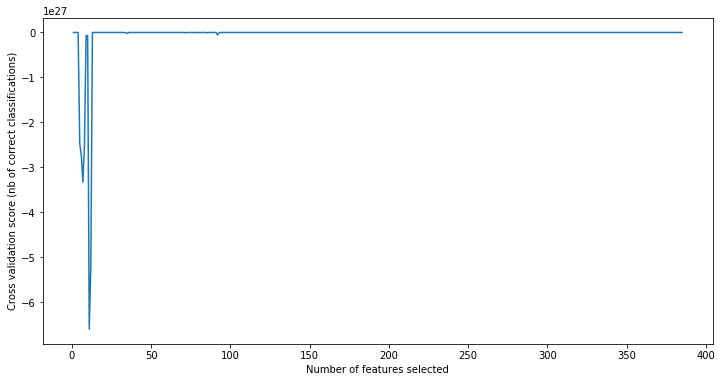

In [72]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## end of automatic feature selection - we can see about 20 features are significant: we will consider only those

In [83]:
#Lets take top 20 features
#colnames=rfecv_df.query(rfecv_df.Rank>15)[index]
#colnames=rfecv_df.loc[rfecv_df['Rank'] > 15, rfecv_df.index]
X_rfetest=X[["x33_t6","x26_t6","x40_t6","x35_t6","x51_t6","x30_t6","x53_t6","x52_t6","x49_t6","x2_t6","x2_t4","x25_t5","x15_t4","x15_t3","x4_t2","x4_t3","x6_t1","x6_t0","x6_t5","x2_t5"]]

In [84]:
X_rfetest.head()

,x33_t6,x26_t6,x40_t6,x35_t6,x51_t6,x30_t6,x53_t6,x52_t6,x49_t6,x2_t6,x2_t4,x25_t5,x15_t4,x15_t3,x4_t2,x4_t3,x6_t1,x6_t0,x6_t5,x2_t5
0,36.14,10.7,89.92,97.35,866.57,553.19,87.2,659.85,140.75,1,1,0,1700,1700.0,6.70,6.70,835.900024,835.900024,835.900024,1
1,36.14,10.7,89.92,97.35,866.57,553.19,87.2,659.85,140.75,1,1,0,1700,1700.0,6.70,6.70,835.900024,835.900024,835.900024,1
2,36.14,10.7,89.92,97.35,866.57,553.19,87.2,659.85,140.75,1,1,0,1700,1700.0,6.70,6.70,835.900024,835.900024,835.900024,1
3,36.14,10.7,89.92,97.35,866.57,553.19,87.2,659.85,140.75,1,1,0,1700,1700.0,6.70,6.70,835.900024,835.900024,835.900024,1
4,36.14,10.7,89.92,97.35,866.57,553.19,87.2,659.85,140.75,1,1,0,1300,1300.0,6.75,6.75,785.599976,785.599976,785.599976,1


In [ ]:
#continue modellling with this subset 

In [87]:
X_trainrfe, X_testrfe, Y_trainrfe, Y_testrfe = train_test_split(X_rfetest, Y, test_size = 0.1, random_state = 0) 

In [92]:
regrfe = CatBoostRegressor()#(objective ='reg:linear', n_estimators = 10, seed = 123)
regrfe.fit(X_trainrfe, Y_trainrfe)

0:	learn: 0.5488364	total: 73.2ms	remaining: 1m 13s
1:	learn: 0.5343983	total: 110ms	remaining: 55.1s
2:	learn: 0.5203887	total: 137ms	remaining: 45.6s
3:	learn: 0.5070069	total: 164ms	remaining: 40.8s
4:	learn: 0.4940440	total: 181ms	remaining: 36.1s
5:	learn: 0.4814976	total: 203ms	remaining: 33.7s
6:	learn: 0.4692631	total: 235ms	remaining: 33.3s
7:	learn: 0.4575477	total: 252ms	remaining: 31.3s
8:	learn: 0.4460698	total: 289ms	remaining: 31.8s
9:	learn: 0.4349905	total: 323ms	remaining: 32s
10:	learn: 0.4242563	total: 360ms	remaining: 32.4s
11:	learn: 0.4140927	total: 387ms	remaining: 31.9s
12:	learn: 0.4042691	total: 400ms	remaining: 30.4s
13:	learn: 0.3948138	total: 425ms	remaining: 29.9s
14:	learn: 0.3857175	total: 450ms	remaining: 29.6s
15:	learn: 0.3768500	total: 481ms	remaining: 29.6s
16:	learn: 0.3682419	total: 516ms	remaining: 29.9s
17:	learn: 0.3600808	total: 545ms	remaining: 29.7s
18:	learn: 0.3522021	total: 567ms	remaining: 29.3s
19:	learn: 0.3445855	total: 594ms	remaini

167:	learn: 0.1638454	total: 6.26s	remaining: 31s
168:	learn: 0.1638032	total: 6.3s	remaining: 31s
169:	learn: 0.1637697	total: 6.32s	remaining: 30.9s
170:	learn: 0.1637583	total: 6.34s	remaining: 30.8s
171:	learn: 0.1636342	total: 6.38s	remaining: 30.7s
172:	learn: 0.1635178	total: 6.41s	remaining: 30.6s
173:	learn: 0.1635096	total: 6.43s	remaining: 30.6s
174:	learn: 0.1634910	total: 6.48s	remaining: 30.5s
175:	learn: 0.1634108	total: 6.52s	remaining: 30.5s
176:	learn: 0.1633409	total: 6.57s	remaining: 30.5s
177:	learn: 0.1633169	total: 6.61s	remaining: 30.5s
178:	learn: 0.1632662	total: 6.67s	remaining: 30.6s
179:	learn: 0.1630992	total: 6.72s	remaining: 30.6s
180:	learn: 0.1630823	total: 6.75s	remaining: 30.5s
181:	learn: 0.1630754	total: 6.79s	remaining: 30.5s
182:	learn: 0.1630613	total: 6.82s	remaining: 30.5s
183:	learn: 0.1630177	total: 6.86s	remaining: 30.4s
184:	learn: 0.1629922	total: 6.88s	remaining: 30.3s
185:	learn: 0.1629662	total: 6.92s	remaining: 30.3s
186:	learn: 0.162

328:	learn: 0.1592390	total: 10.5s	remaining: 21.5s
329:	learn: 0.1592383	total: 10.6s	remaining: 21.4s
330:	learn: 0.1592376	total: 10.6s	remaining: 21.4s
331:	learn: 0.1592366	total: 10.6s	remaining: 21.3s
332:	learn: 0.1592358	total: 10.6s	remaining: 21.3s
333:	learn: 0.1592338	total: 10.6s	remaining: 21.2s
334:	learn: 0.1592332	total: 10.7s	remaining: 21.1s
335:	learn: 0.1592315	total: 10.7s	remaining: 21.1s
336:	learn: 0.1592306	total: 10.7s	remaining: 21s
337:	learn: 0.1590700	total: 10.7s	remaining: 21s
338:	learn: 0.1590696	total: 10.7s	remaining: 21s
339:	learn: 0.1588732	total: 10.8s	remaining: 20.9s
340:	learn: 0.1588729	total: 10.8s	remaining: 20.9s
341:	learn: 0.1588708	total: 10.8s	remaining: 20.8s
342:	learn: 0.1587350	total: 10.9s	remaining: 20.8s
343:	learn: 0.1587338	total: 10.9s	remaining: 20.7s
344:	learn: 0.1587242	total: 10.9s	remaining: 20.7s
345:	learn: 0.1587223	total: 10.9s	remaining: 20.6s
346:	learn: 0.1587220	total: 10.9s	remaining: 20.6s
347:	learn: 0.1587

490:	learn: 0.1580083	total: 13.9s	remaining: 14.4s
491:	learn: 0.1579704	total: 13.9s	remaining: 14.4s
492:	learn: 0.1579699	total: 13.9s	remaining: 14.3s
493:	learn: 0.1579531	total: 14s	remaining: 14.3s
494:	learn: 0.1579526	total: 14s	remaining: 14.3s
495:	learn: 0.1579526	total: 14s	remaining: 14.2s
496:	learn: 0.1579525	total: 14s	remaining: 14.2s
497:	learn: 0.1578422	total: 14.1s	remaining: 14.2s
498:	learn: 0.1578414	total: 14.1s	remaining: 14.1s
499:	learn: 0.1578413	total: 14.1s	remaining: 14.1s
500:	learn: 0.1578407	total: 14.1s	remaining: 14.1s
501:	learn: 0.1578407	total: 14.1s	remaining: 14s
502:	learn: 0.1578406	total: 14.2s	remaining: 14s
503:	learn: 0.1578338	total: 14.2s	remaining: 14s
504:	learn: 0.1578337	total: 14.2s	remaining: 13.9s
505:	learn: 0.1578332	total: 14.2s	remaining: 13.9s
506:	learn: 0.1578331	total: 14.3s	remaining: 13.9s
507:	learn: 0.1578324	total: 14.3s	remaining: 13.8s
508:	learn: 0.1578246	total: 14.3s	remaining: 13.8s
509:	learn: 0.1578245	tota

659:	learn: 0.1570312	total: 17.4s	remaining: 8.98s
660:	learn: 0.1570135	total: 17.5s	remaining: 8.96s
661:	learn: 0.1570135	total: 17.5s	remaining: 8.93s
662:	learn: 0.1570135	total: 17.5s	remaining: 8.89s
663:	learn: 0.1570135	total: 17.5s	remaining: 8.87s
664:	learn: 0.1570135	total: 17.5s	remaining: 8.83s
665:	learn: 0.1570123	total: 17.6s	remaining: 8.8s
666:	learn: 0.1570123	total: 17.6s	remaining: 8.77s
667:	learn: 0.1570123	total: 17.6s	remaining: 8.74s
668:	learn: 0.1570112	total: 17.6s	remaining: 8.71s
669:	learn: 0.1570112	total: 17.6s	remaining: 8.69s
670:	learn: 0.1570112	total: 17.7s	remaining: 8.66s
671:	learn: 0.1570101	total: 17.7s	remaining: 8.63s
672:	learn: 0.1570101	total: 17.7s	remaining: 8.6s
673:	learn: 0.1570101	total: 17.7s	remaining: 8.57s
674:	learn: 0.1570101	total: 17.7s	remaining: 8.54s
675:	learn: 0.1570090	total: 17.8s	remaining: 8.51s
676:	learn: 0.1570082	total: 17.8s	remaining: 8.48s
677:	learn: 0.1570082	total: 17.8s	remaining: 8.45s
678:	learn: 0.

823:	learn: 0.1566751	total: 20.5s	remaining: 4.38s
824:	learn: 0.1566750	total: 20.5s	remaining: 4.36s
825:	learn: 0.1566750	total: 20.6s	remaining: 4.33s
826:	learn: 0.1566746	total: 20.6s	remaining: 4.31s
827:	learn: 0.1566738	total: 20.6s	remaining: 4.28s
828:	learn: 0.1566738	total: 20.6s	remaining: 4.25s
829:	learn: 0.1566735	total: 20.6s	remaining: 4.23s
830:	learn: 0.1565762	total: 20.7s	remaining: 4.2s
831:	learn: 0.1565762	total: 20.7s	remaining: 4.18s
832:	learn: 0.1565757	total: 20.7s	remaining: 4.15s
833:	learn: 0.1565757	total: 20.7s	remaining: 4.12s
834:	learn: 0.1565754	total: 20.7s	remaining: 4.1s
835:	learn: 0.1565725	total: 20.8s	remaining: 4.07s
836:	learn: 0.1565722	total: 20.8s	remaining: 4.05s
837:	learn: 0.1565722	total: 20.8s	remaining: 4.02s
838:	learn: 0.1565722	total: 20.8s	remaining: 4s
839:	learn: 0.1565722	total: 20.8s	remaining: 3.97s
840:	learn: 0.1565722	total: 20.9s	remaining: 3.94s
841:	learn: 0.1565719	total: 20.9s	remaining: 3.92s
842:	learn: 0.156

988:	learn: 0.1558449	total: 24.3s	remaining: 270ms
989:	learn: 0.1558449	total: 24.3s	remaining: 246ms
990:	learn: 0.1558120	total: 24.3s	remaining: 221ms
991:	learn: 0.1558118	total: 24.4s	remaining: 197ms
992:	learn: 0.1557899	total: 24.4s	remaining: 172ms
993:	learn: 0.1557883	total: 24.4s	remaining: 147ms
994:	learn: 0.1557882	total: 24.4s	remaining: 123ms
995:	learn: 0.1557882	total: 24.5s	remaining: 98.2ms
996:	learn: 0.1557877	total: 24.5s	remaining: 73.7ms
997:	learn: 0.1557874	total: 24.5s	remaining: 49.1ms
998:	learn: 0.1557854	total: 24.5s	remaining: 24.5ms
999:	learn: 0.1557467	total: 24.6s	remaining: 0us


In [93]:
#predict Y
Y_predict=regrfe.predict(X_testrfe)
df_predicted=pd.DataFrame( {'Actual':  Y_testrfe,
                            'Predicted':Y_predict }
                            ).reset_index(drop=True)

In [94]:
#Find RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error,r2_score
print('RMSE %.2f'%sqrt(mean_squared_error(Y_test,Y_predict)))
print('r2 %.2f'%r2_score(Y_test,Y_predict))

RMSE 0.11
r2 0.15


In [ ]:
#Not much change in the scores

# Try creating features for avarage of sensors 

In [ ]:
set one default
# RESULTS                  withoutliers       withoutoutliers 
ElasticNet                - 0.23              0.23
GradientBoostingRegressor - 0.27*             0.26
LGBMRegressor             - 0.14              0.12
Ridge(alpha=0.5)          - -6.67              NT
RandomForestRegressor     - 0.02               NT
Lars                      - 0.17               NT
LarsCV                    - 0.24              0.23   
LassoLars                 - -0.00              NT
LassoLarsCV               - 0.27*              NT
CatBoostRegressor         - 0.37*             0.36
HuberRegressor            - 0.04               NT
RANSACRegressor           - -29690133618.93    NT
TheilSenRegressor         - -40.8              NT
PassiveAggressiveRegressor - -0.00             NT
BaggingRegressor           - 0.25              NT
AdaBoostRegressor          - 0.03              NT
SVR                        - 0.01              NT


In [61]:
#Make aggreated features - where t0 - t6 values are combined together to form one variable (sensor value) for simpllicity

In [62]:
#X.iloc[:, 14:21]

In [126]:
new_index=0
start =0
end=7

#X_n=pd.DataFrame(X.iloc[:, 0:6].sum(axis=1),columns = ['t0'])
X_n=pd.DataFrame(X.iloc[:, start:end].sum(axis=1),columns = ['x'+str(start)])

In [127]:
for n in range(54):
 new_index=new_index+1
 start =start+7
 end = end+7
 X_n['x'+str(new_index)]=X.iloc[:, start:end].sum(axis=1)

In [128]:
X_n.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54
0,5210.131312,0.000000,7,157.110602,46.899999,4659.524827,5851.300171,5917.099915,32.199999,1.686420,531.207183,540.301173,3215.203352,3756.234961,6.367611,11900.00,385.00,4866.114193,560,560.0,7.0,200.427321,5260.096882,4.030624,2.5,0,90.343093,5667.174311,0.5,30853.639649,2930.111767,98.49,110.065231,282.220000,278.676087,685.67,294.579595,1,0,462.977148,603.502133,1.415628,7,6.5,0.5,0,597.840878,6.5,4837.535176,1156.293077,132.562019,6015.698962,4497.768223,559.007362,13.586347
1,5149.798112,1.376000,7,193.503536,47.099999,5097.269258,5811.230146,5888.279927,31.999999,1.433870,567.286856,552.029551,3240.158869,3848.310085,6.268661,11904.25,385.66,4881.452383,560,560.0,7.0,201.000000,5365.086428,3.946642,2.0,0,68.297308,5597.738828,1.0,25381.705543,3075.135183,98.98,117.220152,277.440000,275.067149,685.34,357.365262,0,0,473.729840,613.362668,1.435844,7,6.0,1.0,0,611.767339,6.0,3953.131239,1095.366152,124.990456,6144.089933,4758.997349,550.795520,13.570924
2,5132.584550,1.376000,7,195.471296,47.099999,4910.904838,5811.230146,5888.279927,31.999999,2.114559,577.904880,519.536253,3288.485057,3874.806115,6.357467,11904.25,385.66,4873.922650,560,560.0,7.0,201.000000,5386.947292,4.162644,4.0,0,87.595221,5624.715487,1.0,26469.482792,3048.556560,98.98,106.867443,277.440000,276.050783,685.34,356.206851,0,0,490.815262,606.506842,1.469840,7,6.0,1.0,0,604.381611,6.0,3669.897570,1086.365047,126.759030,6032.437739,4818.844470,569.963509,13.399213
3,5135.358010,1.376000,7,194.367763,47.099999,5172.836667,5811.230146,5888.279927,31.999999,1.046400,567.422164,470.638205,3218.741761,3753.052750,6.357727,11904.25,385.66,4884.610044,560,560.0,7.0,201.000000,5402.921469,4.182178,4.0,0,86.842565,5642.226777,1.0,29952.705437,2998.553266,98.98,101.482747,277.114468,275.973179,685.34,352.671625,0,0,506.835855,600.660276,1.451550,7,6.0,1.0,0,603.210993,6.0,4846.319268,1085.308467,126.586630,6008.845395,4872.212444,563.660312,13.422563
4,5133.020650,2.939176,7,131.436967,47.250000,4578.159221,5499.199829,5391.400085,30.800001,1.954800,575.614344,18.553664,3599.041313,3586.981806,5.649018,9100.00,462.00,4933.717253,560,560.0,7.0,175.000000,5034.173594,3.918551,3.5,0,87.260864,5812.023066,0.5,24752.739180,4076.935462,107.49,115.465434,262.220000,261.589128,685.67,685.170185,0,1,393.115662,632.490620,1.587951,7,0.5,6.5,0,625.135707,5.5,3028.834132,821.034331,76.403962,5942.436915,4751.605253,608.030532,15.446857


In [ ]:
#See distributions

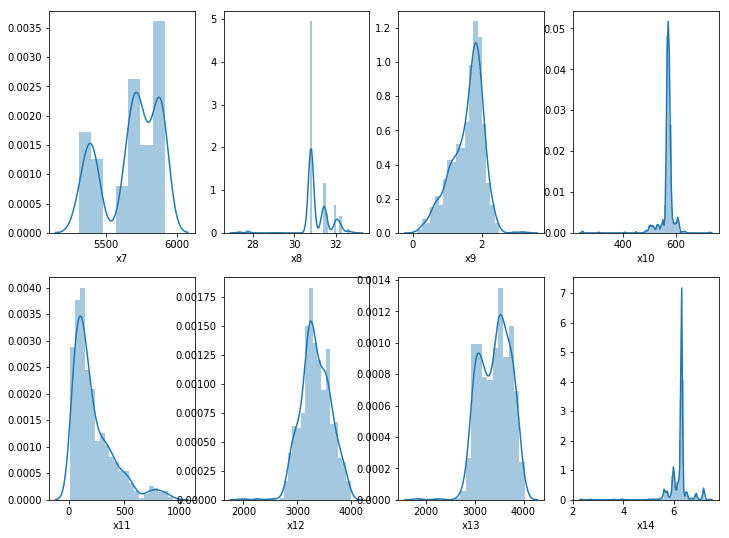

In [130]:
f, ax = plt.subplots(figsize=(12, 9))

plt.subplot(241)
sns.distplot(X_n['x7'])

plt.subplot(242)
sns.distplot(X_n['x8'])

plt.subplot(243)
sns.distplot(X_n['x9'])

plt.subplot(244)
sns.distplot(X_n['x10'])

plt.subplot(245)
sns.distplot(X_n['x11'])

plt.subplot(246)
sns.distplot(X_n['x12'])

plt.subplot(247)
sns.distplot(X_n['x13'])

plt.subplot(248)
sns.distplot(X_n['x14'])



In [68]:
#create linear regression model
lin_reg_scalar = ElasticNet()
#lin_reg_scalar = GradientBoostingRegressor()
##cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
##lin_reg_scalar = LassoCV(cv=cv)

#perform the test,train split within the training data
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(X_n, Y, test_size = 0.3, random_state = 0) #same variable X,Y           
#fit the regressor
lin_reg_scalar.fit(Xt_train, Yt_train)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [69]:
#predict Y again for scalar
Yt_predict=lin_reg_scalar.predict(Xt_test)
df_predicted_scalar=pd.DataFrame(
                            {'Actual':  Yt_test,
                            'Predicted':Yt_predict }
                            ).reset_index(drop=True)

In [70]:
#df_predicted_scalar.head(5)

In [71]:
print('RMSE %.2f'%sqrt(mean_squared_error(Yt_test,Yt_predict)))
print('r2 %.2f'%r2_score(Yt_test,Yt_predict))

RMSE 0.12
r2 0.25


In [72]:
# TRY all other methods
#modellist={'GradientBoostingRegressor':'GradientBoostingRegressor',LGBMRegressor='LGBMRegressor'}
#gbrt=GradientBoostingRegressor(n_estimators=100)
#reg = linear_model.Ridge(alpha=.5)
#reg_rf1=RandomForestRegressor()
#XGBRegressor, LGBMRegressor,CatBoostRegressor
#LogisticRegression,LogisticRegressionCV, RidgeCV, Lars,LarsCV,LassoLars,LassoLarsCV

In [73]:
from sklearn.linear_model import MultiTaskElasticNet,MultiTaskElasticNet,MultiTaskLasso,MultiTaskLasso,HuberRegressor
from sklearn.linear_model import RANSACRegressor,TheilSenRegressor,PassiveAggressiveRegressor,lasso_path,lars_path
from sklearn.linear_model import ridge_regression,SGDRegressor
from sklearn.ensemble import BaggingRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.svm import SVR

In [85]:
#lin_reg_scalar=SVR(kernel = 'rbf')
lin_reg_scalar=RandomForestRegressor()
lin_reg_scalar.fit(Xt_train, Yt_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [86]:
#predict Y again for scalar
Yt_predict=lin_reg_scalar.predict(Xt_test)
df_predicted_scalar=pd.DataFrame(
                            {'Actual':  Yt_test,
                            'Predicted':Yt_predict }
                            ).reset_index(drop=True)

In [87]:
print('RMSE %.2f'%sqrt(mean_squared_error(Yt_test,Yt_predict)))
print('r2 %.2f'%r2_score(Yt_test,Yt_predict))

RMSE 0.14
r2 -0.01


# WE see not much difference in the result

# NEXT drop seemingly insignificant features - 2,8,9,20,25,42 and check

In [343]:
X_n.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,x104,x105,x106,x107
0,5210.131312,1.160000e-11,7,157.110602,46.899999,4659.524827,5851.300171,5917.099915,32.199999,1.686420,531.207183,540.301173,3215.203352,3756.234961,6.367611,11900.00,385.00,4866.114193,560,560.0,7.0,200.427321,5260.096882,4.030624,2.5,0,90.343093,5667.174311,0.5,30853.639649,2930.111767,98.49,110.065231,282.220000,278.676087,685.67,294.579595,1,0,462.977148,603.502133,1.415628,7,6.5,0.5,0,597.840878,6.5,4837.535176,1156.293077,132.562019,6015.698962,4497.768223,559.007362,13.586347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5149.798112,1.376000e+00,7,193.503536,47.099999,5097.269258,5811.230146,5888.279927,31.999999,1.433870,567.286856,552.029551,3240.158869,3848.310085,6.268661,11904.25,385.66,4881.452383,560,560.0,7.0,201.000000,5365.086428,3.946642,2.0,0,68.297308,5597.738828,1.0,25381.705543,3075.135183,98.98,117.220152,277.440000,275.067149,685.34,357.365262,0,0,473.729840,613.362668,1.435844,7,6.0,1.0,0,611.767339,6.0,3953.131239,1095.366152,124.990456,6144.089933,4758.997349,550.795520,13.570924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5132.584550,1.376000e+00,7,195.471296,47.099999,4910.904838,5811.230146,5888.279927,31.999999,2.114559,577.904880,519.536253,3288.485057,3874.806115,6.357467,11904.25,385.66,4873.922650,560,560.0,7.0,201.000000,5386.947292,4.162644,4.0,0,87.595221,5624.715487,1.0,26469.482792,3048.556560,98.98,106.867443,277.440000,276.050783,685.34,356.206851,0,0,490.815262,606.506842,1.469840,7,6.0,1.0,0,604.381611,6.0,3669.897570,1086.365047,126.759030,6032.437739,4818.844470,569.963509,13.399213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5135.358010,1.376000e+00,7,194.367763,47.099999,5172.836667,5811.230146,5888.279927,31.999999,1.046400,567.422164,470.638205,3218.741761,3753.052750,6.357727,11904.25,385.66,4884.610044,560,560.0,7.0,201.000000,5402.921469,4.182178,4.0,0,86.842565,5642.226777,1.0,29952.705437,2998.553266,98.98,101.482747,277.114468,275.973179,685.34,352.671625,0,0,506.835855,600.660276,1.451550,7,6.0,1.0,0,603.210993,6.0,4846.319268,1085.308467,126.586630,6008.845395,4872.212444,563.660312,13.422563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5133.020650,2.939176e+00,7,131.436967,47.250000,4578.159221,5499.199829,5391.400085,30.800001,1.954800,575.614344,18.553664,3599.041313,3586.981806,5.649018,9100.00,462.00,4933.717253,560,560.0,7.0,175.000000,5034.173594,3.918551,3.5,0,87.260864,5812.023066,0.5,24752.739180,4076.935462,107.49,115.465434,262.220000,261.589128,685.67,685.170185,0,1,393.115662,632.490620,1.587951,7,0.5,6.5,0,625.135707,5.5,3028.834132,821.034331,76.403962,5942.436915,4751.605253,608.030532,15.446857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [270]:
X_r=X_n.copy(deep= True) # MAKE a copy

In [271]:
X_r.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53
0,5210.131312,1.160000e-11,7,157.110602,46.899999,4659.524827,5851.300171,5917.099915,32.199999,1.686420,531.207183,540.301173,3215.203352,3756.234961,6.367611,11900.00,385.00,4866.114193,560,560.0,7.0,200.427321,5260.096882,4.030624,2.5,0,90.343093,5667.174311,0.5,30853.639649,2930.111767,98.49,110.065231,282.220000,278.676087,685.67,294.579595,1,0,462.977148,603.502133,1.415628,7,6.5,0.5,0,597.840878,6.5,4837.535176,1156.293077,132.562019,6015.698962,4497.768223,559.007362
1,5149.798112,1.376000e+00,7,193.503536,47.099999,5097.269258,5811.230146,5888.279927,31.999999,1.433870,567.286856,552.029551,3240.158869,3848.310085,6.268661,11904.25,385.66,4881.452383,560,560.0,7.0,201.000000,5365.086428,3.946642,2.0,0,68.297308,5597.738828,1.0,25381.705543,3075.135183,98.98,117.220152,277.440000,275.067149,685.34,357.365262,0,0,473.729840,613.362668,1.435844,7,6.0,1.0,0,611.767339,6.0,3953.131239,1095.366152,124.990456,6144.089933,4758.997349,550.795520
2,5132.584550,1.376000e+00,7,195.471296,47.099999,4910.904838,5811.230146,5888.279927,31.999999,2.114559,577.904880,519.536253,3288.485057,3874.806115,6.357467,11904.25,385.66,4873.922650,560,560.0,7.0,201.000000,5386.947292,4.162644,4.0,0,87.595221,5624.715487,1.0,26469.482792,3048.556560,98.98,106.867443,277.440000,276.050783,685.34,356.206851,0,0,490.815262,606.506842,1.469840,7,6.0,1.0,0,604.381611,6.0,3669.897570,1086.365047,126.759030,6032.437739,4818.844470,569.963509
3,5135.358010,1.376000e+00,7,194.367763,47.099999,5172.836667,5811.230146,5888.279927,31.999999,1.046400,567.422164,470.638205,3218.741761,3753.052750,6.357727,11904.25,385.66,4884.610044,560,560.0,7.0,201.000000,5402.921469,4.182178,4.0,0,86.842565,5642.226777,1.0,29952.705437,2998.553266,98.98,101.482747,277.114468,275.973179,685.34,352.671625,0,0,506.835855,600.660276,1.451550,7,6.0,1.0,0,603.210993,6.0,4846.319268,1085.308467,126.586630,6008.845395,4872.212444,563.660312
4,5133.020650,2.939176e+00,7,131.436967,47.250000,4578.159221,5499.199829,5391.400085,30.800001,1.954800,575.614344,18.553664,3599.041313,3586.981806,5.649018,9100.00,462.00,4933.717253,560,560.0,7.0,175.000000,5034.173594,3.918551,3.5,0,87.260864,5812.023066,0.5,24752.739180,4076.935462,107.49,115.465434,262.220000,261.589128,685.67,685.170185,0,1,393.115662,632.490620,1.587951,7,0.5,6.5,0,625.135707,5.5,3028.834132,821.034331,76.403962,5942.436915,4751.605253,608.030532


In [272]:
X_r.drop(["x2","x8","x9","x20","x25","x42"],axis=1,inplace= True)

In [273]:
#perform the test,train split within the training data
Xt_trainr, Xt_testr, Yt_trainr, Yt_testr = train_test_split(X_r, Y, test_size = 0.3, random_state = 0) #same variable X,Y           
#fit the regressor


In [304]:
lin_reg_scalar = CatBoostRegressor()
#lin_reg_scalar=SVR()  
##cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
##lin_reg_scalar = LassoCV(cv=cv)
lin_reg_scalar.fit(Xt_trainr, Yt_trainr)

0:	learn: 0.5528704	total: 110ms	remaining: 1m 49s
1:	learn: 0.5397358	total: 193ms	remaining: 1m 36s
2:	learn: 0.5263947	total: 264ms	remaining: 1m 27s
3:	learn: 0.5134905	total: 355ms	remaining: 1m 28s
4:	learn: 0.5009939	total: 430ms	remaining: 1m 25s
5:	learn: 0.4887532	total: 494ms	remaining: 1m 21s
6:	learn: 0.4773905	total: 554ms	remaining: 1m 18s
7:	learn: 0.4668321	total: 619ms	remaining: 1m 16s
8:	learn: 0.4554532	total: 683ms	remaining: 1m 15s
9:	learn: 0.4450037	total: 747ms	remaining: 1m 13s
10:	learn: 0.4350293	total: 809ms	remaining: 1m 12s
11:	learn: 0.4252427	total: 879ms	remaining: 1m 12s
12:	learn: 0.4157204	total: 950ms	remaining: 1m 12s
13:	learn: 0.4069586	total: 1.04s	remaining: 1m 13s
14:	learn: 0.3979739	total: 1.14s	remaining: 1m 14s
15:	learn: 0.3892551	total: 1.21s	remaining: 1m 14s
16:	learn: 0.3809768	total: 1.27s	remaining: 1m 13s
17:	learn: 0.3726180	total: 1.29s	remaining: 1m 10s
18:	learn: 0.3647806	total: 1.37s	remaining: 1m 10s
19:	learn: 0.3574024	t

162:	learn: 0.1495480	total: 10.5s	remaining: 53.9s
163:	learn: 0.1493946	total: 10.6s	remaining: 53.9s
164:	learn: 0.1492838	total: 10.7s	remaining: 53.9s
165:	learn: 0.1490646	total: 10.7s	remaining: 53.9s
166:	learn: 0.1490044	total: 10.8s	remaining: 53.8s
167:	learn: 0.1486000	total: 10.8s	remaining: 53.7s
168:	learn: 0.1485164	total: 10.9s	remaining: 53.7s
169:	learn: 0.1482680	total: 11s	remaining: 53.6s
170:	learn: 0.1479414	total: 11s	remaining: 53.5s
171:	learn: 0.1476516	total: 11.1s	remaining: 53.4s
172:	learn: 0.1475492	total: 11.1s	remaining: 53.3s
173:	learn: 0.1475174	total: 11.2s	remaining: 53.2s
174:	learn: 0.1470904	total: 11.3s	remaining: 53.1s
175:	learn: 0.1468549	total: 11.3s	remaining: 53s
176:	learn: 0.1466843	total: 11.4s	remaining: 52.9s
177:	learn: 0.1465334	total: 11.4s	remaining: 52.9s
178:	learn: 0.1464948	total: 11.5s	remaining: 52.8s
179:	learn: 0.1464538	total: 11.6s	remaining: 52.7s
180:	learn: 0.1463655	total: 11.6s	remaining: 52.6s
181:	learn: 0.1463

324:	learn: 0.1239076	total: 20.1s	remaining: 41.8s
325:	learn: 0.1237851	total: 20.2s	remaining: 41.8s
326:	learn: 0.1237155	total: 20.3s	remaining: 41.7s
327:	learn: 0.1232862	total: 20.3s	remaining: 41.6s
328:	learn: 0.1231128	total: 20.4s	remaining: 41.5s
329:	learn: 0.1229697	total: 20.4s	remaining: 41.5s
330:	learn: 0.1228783	total: 20.5s	remaining: 41.4s
331:	learn: 0.1227155	total: 20.5s	remaining: 41.3s
332:	learn: 0.1226891	total: 20.6s	remaining: 41.2s
333:	learn: 0.1226849	total: 20.6s	remaining: 41.1s
334:	learn: 0.1226168	total: 20.7s	remaining: 41s
335:	learn: 0.1221283	total: 20.7s	remaining: 41s
336:	learn: 0.1213548	total: 20.8s	remaining: 40.9s
337:	learn: 0.1212063	total: 20.9s	remaining: 40.8s
338:	learn: 0.1210574	total: 20.9s	remaining: 40.8s
339:	learn: 0.1208548	total: 21s	remaining: 40.7s
340:	learn: 0.1207941	total: 21s	remaining: 40.6s
341:	learn: 0.1207865	total: 21.1s	remaining: 40.6s
342:	learn: 0.1206716	total: 21.1s	remaining: 40.5s
343:	learn: 0.120443

485:	learn: 0.1056008	total: 29.2s	remaining: 30.9s
486:	learn: 0.1053748	total: 29.2s	remaining: 30.8s
487:	learn: 0.1053689	total: 29.3s	remaining: 30.7s
488:	learn: 0.1053004	total: 29.3s	remaining: 30.7s
489:	learn: 0.1052895	total: 29.4s	remaining: 30.6s
490:	learn: 0.1052229	total: 29.5s	remaining: 30.5s
491:	learn: 0.1052105	total: 29.5s	remaining: 30.5s
492:	learn: 0.1051168	total: 29.6s	remaining: 30.4s
493:	learn: 0.1051120	total: 29.6s	remaining: 30.4s
494:	learn: 0.1050923	total: 29.7s	remaining: 30.3s
495:	learn: 0.1050753	total: 29.8s	remaining: 30.2s
496:	learn: 0.1050091	total: 29.8s	remaining: 30.2s
497:	learn: 0.1049091	total: 29.9s	remaining: 30.1s
498:	learn: 0.1048927	total: 29.9s	remaining: 30.1s
499:	learn: 0.1048641	total: 30s	remaining: 30s
500:	learn: 0.1047736	total: 30s	remaining: 29.9s
501:	learn: 0.1047082	total: 30.1s	remaining: 29.9s
502:	learn: 0.1046865	total: 30.2s	remaining: 29.8s
503:	learn: 0.1044087	total: 30.2s	remaining: 29.7s
504:	learn: 0.1043

647:	learn: 0.0943911	total: 38.9s	remaining: 21.1s
648:	learn: 0.0943493	total: 39s	remaining: 21.1s
649:	learn: 0.0943356	total: 39s	remaining: 21s
650:	learn: 0.0942268	total: 39.1s	remaining: 20.9s
651:	learn: 0.0942120	total: 39.1s	remaining: 20.9s
652:	learn: 0.0941869	total: 39.2s	remaining: 20.8s
653:	learn: 0.0941747	total: 39.2s	remaining: 20.8s
654:	learn: 0.0941635	total: 39.3s	remaining: 20.7s
655:	learn: 0.0941506	total: 39.3s	remaining: 20.6s
656:	learn: 0.0941296	total: 39.4s	remaining: 20.6s
657:	learn: 0.0941143	total: 39.5s	remaining: 20.5s
658:	learn: 0.0940848	total: 39.5s	remaining: 20.4s
659:	learn: 0.0940684	total: 39.6s	remaining: 20.4s
660:	learn: 0.0938631	total: 39.6s	remaining: 20.3s
661:	learn: 0.0938053	total: 39.7s	remaining: 20.3s
662:	learn: 0.0937817	total: 39.7s	remaining: 20.2s
663:	learn: 0.0937689	total: 39.8s	remaining: 20.1s
664:	learn: 0.0937593	total: 39.9s	remaining: 20.1s
665:	learn: 0.0937287	total: 39.9s	remaining: 20s
666:	learn: 0.093715

808:	learn: 0.0876320	total: 48.2s	remaining: 11.4s
809:	learn: 0.0875511	total: 48.3s	remaining: 11.3s
810:	learn: 0.0875475	total: 48.3s	remaining: 11.3s
811:	learn: 0.0875458	total: 48.4s	remaining: 11.2s
812:	learn: 0.0875367	total: 48.5s	remaining: 11.1s
813:	learn: 0.0875315	total: 48.5s	remaining: 11.1s
814:	learn: 0.0874577	total: 48.6s	remaining: 11s
815:	learn: 0.0870811	total: 48.7s	remaining: 11s
816:	learn: 0.0870782	total: 48.8s	remaining: 10.9s
817:	learn: 0.0870768	total: 48.8s	remaining: 10.9s
818:	learn: 0.0870294	total: 48.9s	remaining: 10.8s
819:	learn: 0.0870255	total: 49s	remaining: 10.8s
820:	learn: 0.0867105	total: 49.1s	remaining: 10.7s
821:	learn: 0.0867078	total: 49.1s	remaining: 10.6s
822:	learn: 0.0866810	total: 49.2s	remaining: 10.6s
823:	learn: 0.0866186	total: 49.2s	remaining: 10.5s
824:	learn: 0.0866129	total: 49.3s	remaining: 10.5s
825:	learn: 0.0866046	total: 49.4s	remaining: 10.4s
826:	learn: 0.0864301	total: 49.5s	remaining: 10.3s
827:	learn: 0.0864

969:	learn: 0.0816967	total: 58.6s	remaining: 1.81s
970:	learn: 0.0816607	total: 58.7s	remaining: 1.75s
971:	learn: 0.0816570	total: 58.8s	remaining: 1.69s
972:	learn: 0.0816405	total: 58.8s	remaining: 1.63s
973:	learn: 0.0816223	total: 58.9s	remaining: 1.57s
974:	learn: 0.0815959	total: 58.9s	remaining: 1.51s
975:	learn: 0.0815627	total: 59s	remaining: 1.45s
976:	learn: 0.0814854	total: 59s	remaining: 1.39s
977:	learn: 0.0814771	total: 59.1s	remaining: 1.33s
978:	learn: 0.0814742	total: 59.2s	remaining: 1.27s
979:	learn: 0.0814697	total: 59.2s	remaining: 1.21s
980:	learn: 0.0814661	total: 59.3s	remaining: 1.15s
981:	learn: 0.0814213	total: 59.3s	remaining: 1.09s
982:	learn: 0.0814128	total: 59.4s	remaining: 1.03s
983:	learn: 0.0814055	total: 59.4s	remaining: 967ms
984:	learn: 0.0814030	total: 59.5s	remaining: 906ms
985:	learn: 0.0814000	total: 59.6s	remaining: 846ms
986:	learn: 0.0813916	total: 59.6s	remaining: 785ms
987:	learn: 0.0813839	total: 59.7s	remaining: 725ms
988:	learn: 0.08

In [36]:
#predict Y again for scalar
Yt_predictr=lin_reg_scalar.predict(Xt_testr)
df_predicted_scalar=pd.DataFrame(
                            {'Actual':  Yt_testr,
                            'Predicted':Yt_predictr }
                            ).reset_index(drop=True)

In [ ]:
print('RMSE %.2f'%sqrt(mean_squared_error(Yt_testr,Yt_predictr)))
print('r2 %.2f'%r2_score(Yt_testr,Yt_predictr))

In [ ]:
RESULTS: (With removing features though manual inspection)
ElasticNet                - 0.25
GradientBoostingRegressor - 0.25
LGBMRegressor             - 0.25
Ridge(alpha=0.5)          - 0.20
RandomForestRegressor     - 0.16
Lars                      - 0.16
LarsCV                    - 0.25
LassoLars                 - -0.00
LassoLarsCV               - 0.27
CatBoostRegressor         - 0.34*
HuberRegressor            - 0.19
RANSACRegressor           - -6.43
TheilSenRegressor         - 0.13
PassiveAggressiveRegressor - -7.43
BaggingRegressor           - 0.05
AdaBoostRegressor          - 0.05
SVR                        - -0.01
LassoCV            - 0.24   
LarsCV             - 0.25   


In [ ]:
# Again we do not see much difference in the result

# MORE refinements
#lets try to round of the highly negitive numbers to zero 
#Outlier imputation by mode values for a column
#add features with t5-t6 for some of the series [though manual observations] - 
x11_t6
x24_t5	x24_t6 
x28_t5	x28_t6
x30_t5	x30_t6
x35_t5	x35_t6
x40_t5	x40_t6
x43_t5	x43_t6
x47_t5	x47_t6
x50_t5	x50_t6
x53_t5	x53_t6
x54_t5	x54_t6


In [ ]:
# imputation

In [369]:
#X_n.head()

In [368]:
X_n['e11']=X['x11_t6']

In [370]:
X_n['e24']=X['x24_t5']+X['x24_t6']

In [371]:
X_n['e28']=X['x28_t5']+X['x28_t6']

In [372]:
X_n['e30']=X['x30_t5']+X['x30_t6']

In [373]:
X_n['e35']=X['x35_t5']+X['x35_t6']

In [374]:
X_n['e40']=X['x40_t5']+X['x40_t6']

In [375]:
X_n['e43']=X['x43_t5']+X['x43_t6']

In [376]:
X_n['e47']=X['x47_t5']+X['x47_t6']

In [377]:
X_n['e50']=X['x50_t5']+X['x50_t6']

In [378]:
X_n['e53']=X['x53_t5']+X['x53_t6']

In [380]:
X_n['e54']=X['x54_t5']+X['x54_t6']

In [385]:
#X_n.head()
#X_back1=X_n.copy(deep=True)

In [389]:
X_n.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,e11,e24,e28,e30,e35,e40,e43,e47,e50,e53,e54
0,5210.131312,1.160000e-11,7,157.110602,46.899999,4659.524827,5851.300171,5917.099915,32.199999,1.686420,531.207183,540.301173,3215.203352,3756.234961,6.367611,11900.00,385.00,4866.114193,560,560.0,7.0,200.427321,5260.096882,4.030624,1.0,0,90.343093,5667.174311,0.5,30853.639649,2930.111767,98.49,110.065231,282.220000,278.676087,685.67,294.579595,1,0,462.977148,603.502133,1.415628,7,6.5,0.5,0,597.840878,6.5,4837.535176,1156.293077,132.562019,6015.698962,4497.768223,559.007362,13.586347,74.393137,1.5,0.5,946.165005,130.195815,175.020633,1.5,1.5,33.905104,79.166183,3.870253
1,5149.798112,1.376000e+00,7,193.503536,47.099999,5097.269258,5811.230146,5888.279927,31.999999,1.433870,567.286856,552.029551,3240.158869,3848.310085,6.268661,11904.25,385.66,4881.452383,560,560.0,7.0,201.000000,5365.086428,3.946642,1.0,0,68.297308,5597.738828,1.0,25381.705543,3075.135183,98.98,117.220152,277.440000,275.067149,685.34,357.365262,0,0,473.729840,613.362668,1.435844,7,6.0,1.0,0,611.767339,6.0,3953.131239,1095.366152,124.990456,6144.089933,4758.997349,550.795520,13.570924,9.400000,1.0,1.0,1106.380000,194.700000,179.840000,1.0,1.0,29.240000,89.230000,4.060000
2,5132.584550,1.376000e+00,7,195.471296,47.099999,4910.904838,5811.230146,5888.279927,31.999999,2.114559,577.904880,519.536253,3288.485057,3874.806115,6.357467,11904.25,385.66,4873.922650,560,560.0,7.0,201.000000,5386.947292,4.162644,3.0,0,87.595221,5624.715487,1.0,26469.482792,3048.556560,98.98,106.867443,277.440000,276.050783,685.34,356.206851,0,0,490.815262,606.506842,1.469840,7,6.0,1.0,0,604.381611,6.0,3669.897570,1086.365047,126.759030,6032.437739,4818.844470,569.963509,13.399213,9.400000,1.0,1.0,1106.380000,194.700000,179.840000,1.0,1.0,29.240000,89.230000,4.060000
3,5135.358010,1.376000e+00,7,194.367763,47.099999,5172.836667,5811.230146,5888.279927,31.999999,1.046400,567.422164,470.638205,3218.741761,3753.052750,6.357727,11904.25,385.66,4884.610044,560,560.0,7.0,201.000000,5402.921469,4.182178,3.0,0,86.842565,5642.226777,1.0,29952.705437,2998.553266,98.98,101.482747,277.114468,275.973179,685.34,352.671625,0,0,506.835855,600.660276,1.451550,7,6.0,1.0,0,603.210993,6.0,4846.319268,1085.308467,126.586630,6008.845395,4872.212444,563.660312,13.422563,9.400000,1.0,1.0,1106.380000,194.700000,179.840000,1.0,1.0,29.240000,89.230000,4.060000
4,5133.020650,2.939176e+00,7,131.436967,47.250000,4578.159221,5499.199829,5391.400085,30.800001,1.954800,575.614344,18.553664,3599.041313,3586.981806,5.649018,9100.00,462.00,4933.717253,560,560.0,7.0,175.000000,5034.173594,3.918551,2.0,0,87.260864,5812.023066,0.5,24752.739180,4076.935462,107.49,115.465434,262.220000,261.589128,685.67,685.170185,0,1,393.115662,632.490620,1.587951,7,0.5,6.5,0,625.135707,5.5,3028.834132,821.034331,76.403962,5942.436915,4751.605253,608.030532,15.446857,1.745813,1.5,0.5,1102.412927,195.292032,179.236367,0.5,1.5,30.560694,86.496807,4.305063


In [392]:
#remove them from the main aggregations
X_n['x11']=X_n['x11']-X_n['e11']
X_n['x24']= X_n['x24'] - X_n['e24']
X_n['x28']= X_n['x28'] - X_n['e28']
X_n['x30']= X_n['x30'] - X_n['e30']
X_n['x35']= X_n['x35'] - X_n['e35']
X_n['x40']= X_n['x40'] - X_n['e40']
X_n['x43']= X_n['x43'] - X_n['e43']
X_n['x47']= X_n['x47'] - X_n['e47']
X_n['x50']= X_n['x50'] - X_n['e50']
X_n['x53']= X_n['x53'] - X_n['e53']
X_n['x54']= X_n['x54'] - X_n['e54']

In [ ]:
# MODEL AGAIN`

In [395]:
#perform the test,train split within the training data
Xf_train, Xf_test, Yf_train, Yf_test = train_test_split(X_n, Y, test_size = 0.3, random_state = 0) #same variable X,Y           


In [399]:
modelf = LassoLarsCV()
#lin_reg_scalar=SVR()  
##cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
##lin_reg_scalar = LassoCV(cv=cv)
modelf.fit(Xf_train, Yf_train)

LassoLarsCV(copy_X=True, cv=None, eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=1,
      normalize=True, positive=False, precompute='auto', verbose=False)

In [400]:
Yf_predict=modelf.predict(Xf_test)
df_predicted_scalar=pd.DataFrame(
                            {'Actual':  Yf_test,
                            'Predicted':Yf_predict }
                            ).reset_index(drop=True)

In [401]:
print('RMSE %.2f'%sqrt(mean_squared_error(Yf_test,Yf_predict)))
print('r2 %.2f'%r2_score(Yf_test,Yf_predict))

RMSE 0.12
r2 0.26


In [ ]:
ALL RESULTS 1: Comparison

MODEL                                 PLAIN Model      With Reduced Observation    With feature Drops
ElasticNet (alpha=1.0, l1_ratio=0.5)  0.24             0.26                        0.25
GradientBoostingRegressor             0.27             0.28                        0.25
LGBMRegressor                         0.24             0.24                        0.25
Ridge      (alpha=0.5,0.7,0.2)        0.18             0.18                        0.2
RandomForestRegressor                 0.03             0.03                        0.16
Lars                                  0.17             0.03                        0.16
LarsCV                                0.25             0.25                        0.25
LassoLars                             0.00             0.00                        0.00
LassoLarsCV                           0.26             0.26                        0.27
CatBoostRegressor                     0.38             0.39                        0.34
HuberRegressor                        0.24             0.21                        0.19
RANSACRegressor                       0.21             -6.69                       6.43
TheilSenRegressor                     0.27             -0.2                        0.13
PassiveAggressiveRegressor            0.11             -3.95                       -7.43
BaggingRegressor                      0.08             0.01                        0.05
AdaBoostRegressor                     0.04             0.07                        0.05
SVR                                   0.03             0.01                        0.01

NOTES: 
In general removel of features either by EDA or through RFECV did not bring about much changes in the model performances.
CatBoostRegressor outclassed other models in all the cases
Removal of outliers (miniscule values that were power of -11) did not help. In fact that affeceted negetively
NEXTSTEPS: Understand the models from fundamentals and decipher why there was - no effect, negetive effect,positive effect with differing techniques.
    
    
    
    